In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import cross_validation as cv

from sklearn.metrics import mean_squared_error
from math import sqrt

import re

#import gensim for NLP
from gensim.models import doc2vec

# nltk processing
import nltk
from nltk.tag import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# load the data
csv_file = 'film_book_combo_ver1.csv'
data=pd.read_csv(csv_file)

In [3]:
# Due to memory limitation, we are going to reduce this database to less than 10k to test our models
data.shape

(47213, 7)

In [4]:
#split the data to the film/book dataseets
film=data[data['type']=='film']
book=data[data['type']=='book']

In [5]:
#checking the ratings for film and books
print 'Min total rating for film: {}'.format(film.total_ratings.min())
print 'Max total rating for film: {}'.format(film.total_ratings.max())
print '---------------------------------------------------------'
print 'Min total rating for book: {}'.format(book.total_ratings.min())
print 'Max total rating for book: {}'.format(book.total_ratings.max())

Min total rating for film: 1
Max total rating for film: 91921
---------------------------------------------------------
Min total rating for book: 11
Max total rating for book: 22806


In [6]:
#what are the film/books
print 'Highly rated film'
print '---------------------------------------------------------'
print film[film['total_ratings']==91921].title
print 'Lowest rated film'
print '---------------------------------------------------------'
print film[film['total_ratings']==1].title

print 'Highly rated book'
print '---------------------------------------------------------'
print book[book['total_ratings']==22806].title
print 'Lowest rated book'
print '---------------------------------------------------------'
print book[book['total_ratings']==11].title

Highly rated film
---------------------------------------------------------
20037    Forrest Gump (1994)
Name: title, dtype: object
Lowest rated film
---------------------------------------------------------
7752                            $1,000 on the Black (1966)
7753                             $100,000 for Ringo (1965)
7757                                        '49-'17 (1917)
7762               'Master Harold' ... And the Boys (2010)
7765                              'Pimpernel' Smith (1941)
7787                             ...E fuori nevica! (2014)
7792                     008: Operation Exterminate (1966)
7794                009-1: The End of the Beginning (2013)
7797                               1 Litre of Tears (2005)
7798                                        1 Night (2017)
7805               10 Billion: What's On Your Plate (2015)
7819                        10%: What Makes a Hero? (2013)
7821                                    10,000 Days (2014)
7828                     

In [7]:
# I've decided to be more critical of the movie dataset is much bigger than the book dataset
#This is the top 10% for the film database
print np.percentile(film['total_ratings'], 90)

#This is the top 10% for the film database
print np.percentile(book['total_ratings'], 50)

854.0
237.0


In [8]:
#How many movies will there be if we take only the top 10%?
print len(film[film['total_ratings'] > 854.0].title)
#How many movies will there be if we take only the top 50%?
print len(book[book['total_ratings'] > 237.0].title)

3944
3870


In [9]:
#Fair enough we will proceed to create the reduced database
r_film=film[film['total_ratings'] > 854.0]
r_book=book[book['total_ratings'] > 237.0]

frame = [r_film,r_book]
reduced_db = pd.concat(frame)

In [10]:
reduced_db.sample(5)

,id,title,type,average_rating,total_ratings,genre,summary
33614,91790,Pretty in Pink (1986),film,3.358744,8835,Comedy|Drama|Romance,Teenager Andie is one of the not-so-popular gi...
32453,70510,Paper Moon (1973),film,3.891365,1436,Comedy|Crime|Drama,"Adapted from the novel, ""Addie Pray"" (1971) by..."
25379,102175,Jungle Fever (1991),film,3.175364,1169,Drama|Romance,A successful and married black man contemplate...
23911,122541,"Ideal Husband, An (1999)",film,3.744671,3096,Comedy|Romance,Sir Robert Chiltern is a successful Government...
911,51893,Thus Spoke Zarathustra,book,4.050000,736,Philosophy|Classics|Nonfiction|European Litera...,Friedrich Nietzsche's most accessible and infl...


In [11]:
# save the dataset to csv
reduced_db.to_csv('film_book_combo_reduced.csv', encoding='utf-8', index=False)

# Basic EDA

In [12]:
df=reduced_db.copy()

# Checking the word-count of summary
df['word_count'] = df['summary'].apply(lambda x: len(str(x).split(" ")))

In [13]:
#What the maximum and minimum word count for the dataset summary?
print 'The max word count in summmary is: {}'.format(df['word_count'].max())
print 'The min word count in summmary is: {}'.format(df['word_count'].min())

The max word count in summmary is: 643
The min word count in summmary is: 2


In [14]:
#let's investigate the wordcount further
df[df['word_count']<10]
# we can drop these books

,id,title,type,average_rating,total_ratings,genre,summary,word_count
48,428263,"Eclipse (Twilight, #3)",book,3.69,9620,Young Adult|Fantasy|Romance|Paranormal|Vampire...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,2
50,113436,"Eragon (The Inheritance Cycle, #1)",book,3.86,7040,Fantasy|Young Adult|Fiction|Fantasy|Dragons,Fantasy|Young Adult|Fiction|Fantasy|Dragons,2
59,119322,"The Golden Compass (His Dark Materials, #1)",book,3.94,8192,Fantasy|Young Adult|Fiction,Fantasy|Young Adult|Fiction,2
62,10917,My Sister's Keeper,book,4.06,7192,Fiction|Contemporary|Womens Fiction|Chick Lit,Fiction|Contemporary|Womens Fiction|Chick Lit,3
67,11735983,"Insurgent (Divergent, #2)",book,4.07,8263,Young Adult|Science Fiction|Dystopia|Fiction|F...,Young Adult|Science Fiction|Dystopia|Fiction|F...,3


In [15]:
df = df[df['word_count']>10]

In [16]:
df['genre_count'] = df['genre'].apply(lambda x: len(str(x).split("|")))

In [17]:
df.head()

,id,title,type,average_rating,total_ratings,genre,summary,word_count,genre_count
7774,96734,"'burbs, The (1989)",film,3.108748,3715,Comedy,This story takes place in a typical American n...,79,1
7781,92494,*batteries not included (1987),film,3.255363,1958,Children|Comedy|Fantasy|Sci-Fi,A group of tenants in an apartment block are b...,61,4
7782,92494,*batteries not included (1987),film,3.255363,1958,Children|Comedy|Fantasy|Sci-Fi,A group of tenants in an apartment block are b...,61,4
7786,78718,...And Justice for All (1979),film,3.630727,1266,Drama|Thriller,"When a judge is charged with rape, Arthur Kirk...",47,2
7807,1179933,10 Cloverfield Lane (2016),film,3.683926,1941,Thriller,"After a car accident, Michelle awakens to find...",95,1


In [18]:
df=df.reset_index(drop=True)

In [19]:
# What's the max genre a book/film can have?
df.genre_count.max()

18

In [20]:
df[df.genre_count==18]

,id,title,type,average_rating,total_ratings,genre,summary,word_count,genre_count
4571,6917952,"Burned (House of Night, #7)",book,3.98,1134,Young Adult|Fantasy|Paranormal|Fantasy|Superna...,"WHEN FRIENDS STOP TRUSTING EACH OTHER, DARKNES...",221,18


In [21]:
genres_count= {}
for row in range(df['id'].count()):
    for genre in df['genre'][row].split("|"):
        if(genre != ''):
            genres_count[genre]= genres_count.get(genre,0)+1
        
genres_count

{'18th Century': 1,
 '19th Century': 22,
 '20th Century': 1,
 'Abandoned': 31,
 'Abuse': 10,
 'Academic': 71,
 'Action': 967,
 'Adoption': 1,
 'Adult': 104,
 'Adult Fiction': 102,
 'Adventure': 836,
 'Africa': 28,
 'African American': 22,
 'African Literature': 1,
 'Aliens': 7,
 'Alternate History': 6,
 'Amazon': 1,
 'American': 50,
 'American Civil War': 1,
 'American History': 26,
 'American Revolution': 2,
 'Ancient': 2,
 'Ancient History': 2,
 'Angels': 21,
 'Animals': 63,
 'Animation': 218,
 'Anime': 1,
 'Anthologies': 3,
 'Anthropology': 6,
 'Apocalyptic': 40,
 'Architecture': 1,
 'Art': 33,
 'Art Design': 1,
 'Art History': 4,
 'Arthurian': 3,
 'Asia': 21,
 'Asian Literature': 25,
 'Astronomy': 4,
 'Atheism': 5,
 'Audiobook': 127,
 'Australia': 9,
 'Autobiography': 208,
 'Banned Books': 1,
 'Baseball': 3,
 'Batman': 6,
 'Bdsm': 17,
 'Biography': 208,
 'Biography Memoir': 20,
 'Biology': 11,
 'Birds': 1,
 'Book Club': 36,
 'Books About Books': 8,
 'Botswana': 4,
 'British Literat

In [22]:
# What are the top 10 genre for book/film?
# plt.bar(genres_count.keys(), genres_count.values(),color='g')
from heapq import nlargest
nlargest(10, genres_count, key=genres_count.get)

['Fiction',
 'Fantasy',
 'Romance',
 'Drama',
 'Comedy',
 'Thriller',
 'Mystery',
 'Action',
 'Young Adult',
 'Crime']

In [23]:
sorted_genres = sorted(genres_count.iteritems(), key=lambda (k, v): (-v, k))[:10]
sorted_genres

[('Fiction', 2678),
 ('Fantasy', 2451),
 ('Romance', 1904),
 ('Drama', 1842),
 ('Comedy', 1544),
 ('Thriller', 1532),
 ('Mystery', 1288),
 ('Action', 967),
 ('Young Adult', 907),
 ('Crime', 865)]

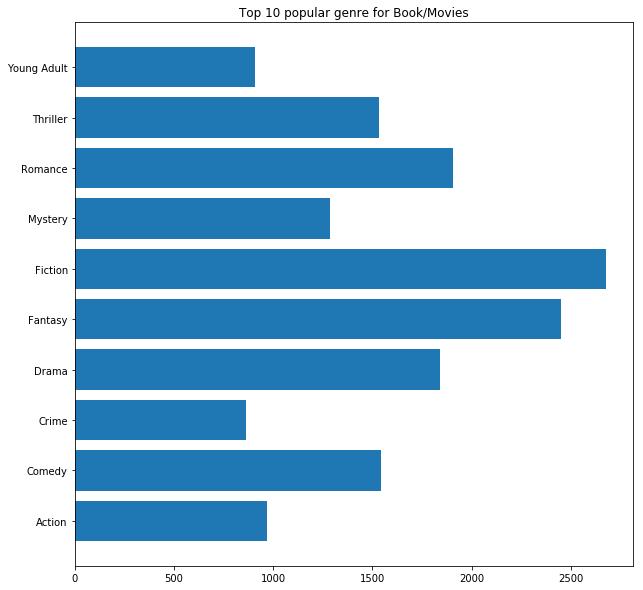

In [24]:
x, y = zip(*sorted_genres)
plt.figure(figsize=(10,10))
plt.barh(x, y)
plt.title('Top 10 popular genre for Book/Movies')
plt.show()

In [25]:
genres_count_book= {}

book=df[df['type']=='book']
book=book.reset_index(drop=True)

for row in range(book['id'].count()):
    for genre in book['genre'][row].split("|"):
        if(genre != ''):
            genres_count_book[genre]= genres_count_book.get(genre,0)+1
            
genres_count_book

{'18th Century': 1,
 '19th Century': 22,
 '20th Century': 1,
 'Abandoned': 31,
 'Abuse': 10,
 'Academic': 71,
 'Action': 26,
 'Adoption': 1,
 'Adult': 104,
 'Adult Fiction': 102,
 'Adventure': 148,
 'Africa': 28,
 'African American': 22,
 'African Literature': 1,
 'Aliens': 7,
 'Alternate History': 6,
 'Amazon': 1,
 'American': 50,
 'American Civil War': 1,
 'American History': 26,
 'American Revolution': 2,
 'Ancient': 2,
 'Ancient History': 2,
 'Angels': 21,
 'Animals': 63,
 'Anime': 1,
 'Anthologies': 3,
 'Anthropology': 6,
 'Apocalyptic': 40,
 'Architecture': 1,
 'Art': 33,
 'Art Design': 1,
 'Art History': 4,
 'Arthurian': 3,
 'Asia': 21,
 'Asian Literature': 25,
 'Astronomy': 4,
 'Atheism': 5,
 'Audiobook': 127,
 'Australia': 9,
 'Autobiography': 208,
 'Banned Books': 1,
 'Baseball': 3,
 'Batman': 6,
 'Bdsm': 17,
 'Biography': 208,
 'Biography Memoir': 20,
 'Biology': 11,
 'Birds': 1,
 'Book Club': 36,
 'Books About Books': 8,
 'Botswana': 4,
 'British Literature': 30,
 'Buddhism

In [26]:
sorted_genres = sorted(genres_count_book.iteritems(), key=lambda (k, v): (-v, k))[:10]
sorted_genres

[('Fiction', 2678),
 ('Fantasy', 2074),
 ('Romance', 1179),
 ('Mystery', 1006),
 ('Young Adult', 907),
 ('Historical', 796),
 ('Classics', 635),
 ('Paranormal', 609),
 ('Contemporary', 581),
 ('Thriller', 572)]

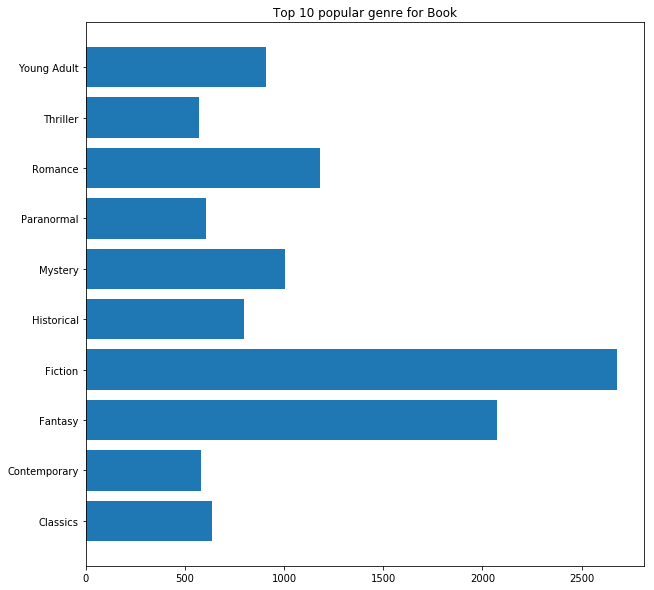

In [27]:
x, y = zip(*sorted_genres)
plt.figure(figsize=(10,10))
plt.barh(x, y)
plt.title('Top 10 popular genre for Book')
plt.show()

In [28]:
genres_count_film= {}

film=df[df['type']=='film']
film=film.reset_index(drop=True)

for row in range(film['id'].count()):
    for genre in film['genre'][row].split("|"):
        if(genre != ''):
            genres_count_film[genre]= genres_count_film.get(genre,0)+1
            
genres_count_film

{'Action': 941,
 'Adventure': 688,
 'Animation': 218,
 'Children': 339,
 'Comedy': 1507,
 'Crime': 545,
 'Documentary': 75,
 'Drama': 1787,
 'Fantasy': 377,
 'Film-Noir': 40,
 'Horror': 355,
 'IMAX': 118,
 'Musical': 157,
 'Mystery': 282,
 'Romance': 725,
 'Sci-Fi': 512,
 'Thriller': 960,
 'War': 170,
 'Western': 73}

In [29]:
sorted_genres = sorted(genres_count_film.iteritems(), key=lambda (k, v): (-v, k))[:10]
sorted_genres

[('Drama', 1787),
 ('Comedy', 1507),
 ('Thriller', 960),
 ('Action', 941),
 ('Romance', 725),
 ('Adventure', 688),
 ('Crime', 545),
 ('Sci-Fi', 512),
 ('Fantasy', 377),
 ('Horror', 355)]

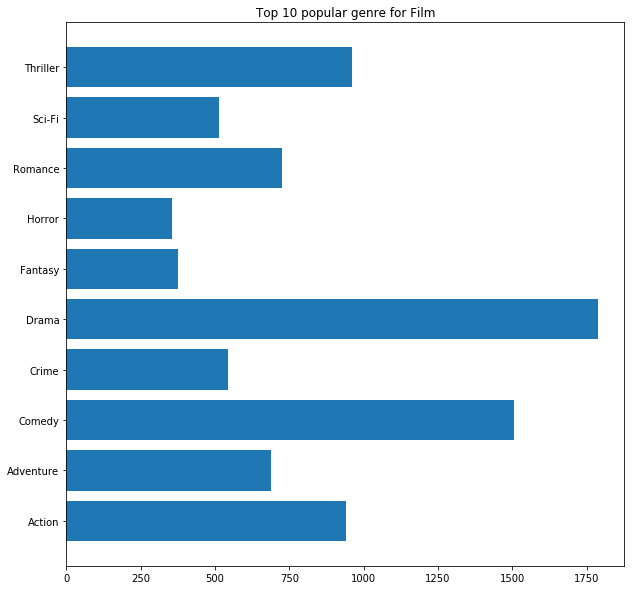

In [30]:
x, y = zip(*sorted_genres)
plt.figure(figsize=(10,10))
plt.barh(x, y)
plt.title('Top 10 popular genre for Film')
plt.show()

The top 3 popular genre amongst book and film are Fiction, Fantasy and Romance. <br>
The top 3 popular genre amongst book are Fiction, Fantasy and Romance. <br>
The top 3 popular genre for film are Drama, Comedy and Thriller.<br>

Fiction, Fantasy and Romance tends to dominate since there's a sizable amount coming from books.

In [31]:
# preparing the data for NLP, both genre and summary will be in lowercase. For summary, the text will be removed of special characters as well.
def cleantext(text):
    clean = " ".join(re.findall("[a-zA-Z]+", text))
    clean = clean.lower()
    return clean

In [32]:
df['genre_feature'] = df['genre']
df['genre'] = df['genre'].apply(lambda x: x.lower())
# Break up the big genre string into a string array
df['genre'] = df['genre'].str.split('|')
# Convert genres to string value
df['genre'] = df['genre'].fillna("").astype('str')

In [33]:
df.head()

,id,title,type,average_rating,total_ratings,genre,summary,word_count,genre_count,genre_feature
0,96734,"'burbs, The (1989)",film,3.108748,3715,['comedy'],This story takes place in a typical American n...,79,1,Comedy
1,92494,*batteries not included (1987),film,3.255363,1958,"['children', 'comedy', 'fantasy', 'sci-fi']",A group of tenants in an apartment block are b...,61,4,Children|Comedy|Fantasy|Sci-Fi
2,92494,*batteries not included (1987),film,3.255363,1958,"['children', 'comedy', 'fantasy', 'sci-fi']",A group of tenants in an apartment block are b...,61,4,Children|Comedy|Fantasy|Sci-Fi
3,78718,...And Justice for All (1979),film,3.630727,1266,"['drama', 'thriller']","When a judge is charged with rape, Arthur Kirk...",47,2,Drama|Thriller
4,1179933,10 Cloverfield Lane (2016),film,3.683926,1941,['thriller'],"After a car accident, Michelle awakens to find...",95,1,Thriller


In [34]:
df['summary'] = df['summary'].apply(cleantext)

In [35]:
#recheck the word_count
df['word_count'] = df['summary'].apply(lambda x: len(str(x).split(" ")))

In [36]:
df[df['word_count']<10]

,id,title,type,average_rating,total_ratings,genre,summary,word_count,genre_count,genre_feature
4418,17214,Starship Troopers,book,3.99,1809,"['science fiction', 'fiction', 'classics']",,1,3,Science Fiction|Fiction|Classics
4627,2199,Team of Rivals: The Political Genius of Abraha...,book,4.30,827,"['history', 'nonfiction', 'biography', 'politi...",team of rivals,3,8,History|Nonfiction|Biography|Politics|North Am...
4713,30,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,book,4.59,1400,"['fantasy', 'fiction', 'classics']",,1,3,Fantasy|Fiction|Classics
5074,16031620,الفيل الأزرق,book,3.80,387,['novels'],,1,1,Novels
5167,16081961,الأسود يليق بك,book,3.72,335,"['novels', 'romance', 'fiction', 'romantic', '...",,1,9,Novels|Romance|Fiction|Romantic|Literature|Unf...
5380,28815,Influence: The Psychology of Persuasion,book,4.18,344,"['psychology', 'business', 'nonfiction', 'self...",,1,5,Psychology|Business|Nonfiction|Self Help|Leade...
5453,20317106,هيبتا,book,3.82,328,['novels'],,1,1,Novels
5581,7119070,أحببتك أكثر مما ينبغي,book,3.67,259,"['novels', 'romance']",,1,2,Novels|Romance
5664,3554772,عزازيل,book,4.07,390,"['novels', 'fiction', 'historical', 'historica...",,1,4,Novels|Fiction|Historical|Historical Fiction
5889,13637412,ساق البامبو,book,4.25,326,['novels'],,1,1,Novels


In [37]:
df = df[df['word_count']>10]
df.reset_index(drop=True)

,id,title,type,average_rating,total_ratings,genre,summary,word_count,genre_count,genre_feature
0,96734,"'burbs, The (1989)",film,3.108748,3715,['comedy'],this story takes place in a typical american n...,79,1,Comedy
1,92494,*batteries not included (1987),film,3.255363,1958,"['children', 'comedy', 'fantasy', 'sci-fi']",a group of tenants in an apartment block are b...,62,4,Children|Comedy|Fantasy|Sci-Fi
2,92494,*batteries not included (1987),film,3.255363,1958,"['children', 'comedy', 'fantasy', 'sci-fi']",a group of tenants in an apartment block are b...,62,4,Children|Comedy|Fantasy|Sci-Fi
3,78718,...And Justice for All (1979),film,3.630727,1266,"['drama', 'thriller']",when a judge is charged with rape arthur kirkl...,47,2,Drama|Thriller
4,1179933,10 Cloverfield Lane (2016),film,3.683926,1941,['thriller'],after a car accident michelle awakens to find ...,96,1,Thriller
5,147800,10 Things I Hate About You (1999),film,3.515108,14793,"['comedy', 'romance']",adapted from william shakespeare s play the ta...,220,2,Comedy|Romance
6,443649,"10,000 BC (2008)",film,2.534293,2639,"['adventure', 'romance', 'thriller']",a prehistoric epic that follows a young mammot...,93,3,Adventure|Romance|Thriller
7,115433,101 Dalmatians (1996),film,3.068799,10240,"['adventure', 'children', 'comedy']",after a wild chase in the bustling streets of ...,135,3,Adventure|Children|Comedy
8,55254,101 Dalmatians (One Hundred and One Dalmatians...,film,3.415783,9434,"['adventure', 'animation', 'children']",pongo and perdita have a litter of puppies cru...,59,3,Adventure|Animation|Children
9,211181,102 Dalmatians (2000),film,2.398457,2009,"['children', 'comedy']",after a spot of therapy cruella de vil is rele...,77,2,Children|Comedy


In [38]:
df.shape

(7795, 10)

# Content based Recommendation (By Genre or Summary)

In [39]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['genre'])
tfidf_matrix.shape

(7795, 2759)

In [40]:
# Using cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [41]:
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [42]:
def get_genreRecommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the media indices
    media_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar media
    print "For the genre recommendataion of {}:".format(df['title'].iloc[idx])
    return df[['title','type','genre']].iloc[media_indices]

In [43]:
def search_title(title, media='all'):
    try:
        search = df[df['title'].str.contains(title)]
        if(media=='book'):
           search = search[search['type']=='book']
        elif(media=='film'):
            search = search[search['type']=='film']
        else:
            search
    except:
        search = 'Error! Title not found'
    print search[['title','type']]

search_title('Harry Potter')

                                                  title  type
1534     Harry Potter and the Chamber of Secrets (2002)  film
1535  Harry Potter and the Deathly Hallows: Part 1 (...  film
1536  Harry Potter and the Deathly Hallows: Part 2 (...  film
1537         Harry Potter and the Goblet of Fire (2005)  film
1538   Harry Potter and the Order of the Phoenix (2007)  film
1539    Harry Potter and the Prisoner of Azkaban (2004)  film
1540    Harry Potter and the Prisoner of Azkaban (2004)  film
1541  Harry Potter and the Sorcerer's Stone (a.k.a. ...  film
3944  Harry Potter and the Sorcerer's Stone (Harry P...  book
3960  Harry Potter and the Prisoner of Azkaban (Harr...  book
3963  Harry Potter and the Order of the Phoenix (Har...  book
3965  Harry Potter and the Chamber of Secrets (Harry...  book
3966  Harry Potter and the Goblet of Fire (Harry Pot...  book
3967  Harry Potter and the Deathly Hallows (Harry Po...  book
3969  Harry Potter and the Half-Blood Prince (Harry ...  book
5636    

In [44]:
# This is the movie 
get_genreRecommendations('Batman & Robin (1997)')

For the genre recommendataion of Batman & Robin (1997):


,title,type,genre
2391,"Mummy: Tomb of the Dragon Emperor, The (2008)",film,"['action', 'adventure', 'fantasy', 'thriller']"
3516,The Scorpion King (2002),film,"['action', 'adventure', 'fantasy', 'thriller']"
15,"13th Warrior, The (1999)",film,"['action', 'adventure', 'fantasy']"
57,"7th Voyage of Sinbad, The (1958)",film,"['action', 'adventure', 'fantasy']"
351,"Beastmaster, The (1982)",film,"['action', 'adventure', 'fantasy']"
757,Conan the Destroyer (1984),film,"['action', 'adventure', 'fantasy']"
1011,Dragonheart (1996),film,"['action', 'adventure', 'fantasy']"
1012,Dragonslayer (1981),film,"['action', 'adventure', 'fantasy']"
1103,Eragon (2006),film,"['action', 'adventure', 'fantasy']"
1602,Highlander (1986),film,"['action', 'adventure', 'fantasy']"


In [45]:
def get_Recommendations(title, media='all', cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    #return sim_scores
    media_indices = [i[0] for i in sim_scores]
    score_indices = [i[1] for i in sim_scores]
    
    data = df[['title','type','genre']].iloc[media_indices]
    data['cos_sin score']=score_indices
    if media=='book':
        data = data[data['type']=='book']
    elif media == 'film':
        data = data[data['type']=='film']
        
    print "For the recommendataion of {}:".format(df['title'].iloc[idx])
    return data.iloc[1:11]
#     # Get the scores of the 10 most similar movies
#     sim_scores = sim_scores[1:11]

#     # Get the media indices
#     media_indices = [i[0] for i in sim_scores]

#     # Return the top 10 most similar media
#     print "For the genre recommendataion of {}:".format(df['title'].iloc[idx])
#     return df[['title','type','genre']].iloc[media_indices]

In [46]:
get_Recommendations('Batman & Robin (1997)','book')

For the recommendataion of Batman & Robin (1997):


,title,type,genre,cos_sin score
6636,"Odd Hours (Odd Thomas, #4)",book,"['fiction', 'fantasy', 'thriller', 'horror']",0.423163
5102,Horns,book,"['horror', 'fiction', 'fantasy', 'thriller', '...",0.422960
5439,NOS4A2,book,"['horror', 'fiction', 'fantasy', 'thriller', '...",0.387381
7114,Eaters of the Dead,book,"['fiction', 'historical', 'historical fiction'...",0.378607
5195,"The Battle for Skandia (Ranger's Apprentice, #4)",book,"['young adult', 'adventure', 'fantasy', 'ficti...",0.358476
4973,"Red Seas Under Red Skies (Gentleman Bastard, #2)",book,"['fantasy', 'fiction', 'adventure', 'fantasy',...",0.357257
4021,"Jurassic Park (Jurassic Park, #1)",book,"['science fiction', 'fiction', 'thriller', 'ad...",0.354622
4183,"Odd Thomas (Odd Thomas, #1)",book,"['horror', 'fiction', 'mystery', 'fantasy', 't...",0.346585
6383,"Theft of Swords (The Riyria Revelations, #1-2)",book,"['fantasy', 'fiction', 'fantasy', 'epic fantas...",0.307917
4720,Journey to the Center of the Earth (Extraordin...,book,"['classics', 'science fiction', 'fiction', 'ad...",0.298557


In [47]:
get_Recommendations('Batman & Robin (1997)','film')

For the recommendataion of Batman & Robin (1997):


,title,type,genre,cos_sin score
2391,"Mummy: Tomb of the Dragon Emperor, The (2008)",film,"['action', 'adventure', 'fantasy', 'thriller']",1.000000
3516,The Scorpion King (2002),film,"['action', 'adventure', 'fantasy', 'thriller']",1.000000
15,"13th Warrior, The (1999)",film,"['action', 'adventure', 'fantasy']",0.768907
57,"7th Voyage of Sinbad, The (1958)",film,"['action', 'adventure', 'fantasy']",0.768907
351,"Beastmaster, The (1982)",film,"['action', 'adventure', 'fantasy']",0.768907
757,Conan the Destroyer (1984),film,"['action', 'adventure', 'fantasy']",0.768907
1011,Dragonheart (1996),film,"['action', 'adventure', 'fantasy']",0.768907
1012,Dragonslayer (1981),film,"['action', 'adventure', 'fantasy']",0.768907
1103,Eragon (2006),film,"['action', 'adventure', 'fantasy']",0.768907
1602,Highlander (1986),film,"['action', 'adventure', 'fantasy']",0.768907


In [48]:
# Now we are going to move ahead to using the summary instead of genre
tfidf_matrix_summary = tf.fit_transform(df['summary'])
tfidf_matrix_summary.shape

(7795, 474720)

In [49]:
cosine_sim2 = linear_kernel(tfidf_matrix_summary, tfidf_matrix_summary)

In [50]:
cosine_sim2.shape

(7795L, 7795L)

In [135]:
search_title('Batman: Arkham Asylum')

                                                  title  type
5732  Batman: Arkham Asylum - A Serious House on Ser...  book


In [51]:
get_Recommendations('Batman & Robin (1997)','book',cosine_sim2)

For the recommendataion of Batman & Robin (1997):


,title,type,genre,cos_sin score
5732,Batman: Arkham Asylum - A Serious House on Ser...,book,"['sequential art', 'graphic novels', 'sequenti...",0.095434
7135,Batman: Hush,book,"['sequential art', 'comics', 'sequential art',...",0.076284
4360,Batman: The Dark Knight Returns (The Dark Knig...,book,"['sequential art', 'comics', 'sequential art',...",0.059251
5881,"Halo (Halo, #1)",book,"['paranormal', 'angels', 'young adult', 'fanta...",0.044905
6384,"Necessary Lies (Necessary Lies, #1)",book,"['historical', 'historical fiction', 'fiction'...",0.044550
5042,"Poison Study (Study, #1)",book,"['fantasy', 'young adult', 'romance', 'fantasy...",0.040005
6339,Icy Sparks,book,['fiction'],0.037180
7244,The Rule of Four,book,"['fiction', 'mystery', 'thriller', 'historical...",0.035633
5306,Batman: The Long Halloween,book,"['sequential art', 'comics', 'sequential art',...",0.034834
6429,"Batman, Volume 1: The Court of Owls",book,"['sequential art', 'comics', 'sequential art',...",0.031435


In [52]:
get_Recommendations('Batman & Robin (1997)','film',cosine_sim2)

For the recommendataion of Batman & Robin (1997):


,title,type,genre,cos_sin score
331,Batman Returns (1992),film,"['action', 'crime']",0.098343
327,Batman (1966),film,"['action', 'adventure', 'comedy']",0.079247
3739,"Village, The (2004)",film,"['drama', 'mystery', 'thriller']",0.075938
854,"Dark Knight, The (2008)",film,"['action', 'crime', 'drama', 'imax']",0.070342
330,Batman Forever (1995),film,"['action', 'adventure', 'comedy', 'crime']",0.068937
328,Batman (1989),film,"['action', 'crime', 'thriller']",0.067157
2743,Poison Ivy (1992),film,"['drama', 'thriller']",0.065947
334,"Batman: The Dark Knight Returns, Part 1 (2012)",film,"['action', 'animation', 'sci-fi']",0.059653
335,"Batman: The Dark Knight Returns, Part 2 (2013)",film,"['action', 'animation']",0.052181
333,Batman: Mask of the Phantasm (1993),film,"['animation', 'children']",0.049110


# Content based Recommendation (With both Genre and Summary)

In [53]:
cs = cosine_sim+cosine_sim2

In [54]:
cs.shape

(7795L, 7795L)

In [55]:
get_Recommendations('Batman & Robin (1997)','book',cs)

For the recommendataion of Batman & Robin (1997):


,title,type,genre,cos_sin score
5102,Horns,book,"['horror', 'fiction', 'fantasy', 'thriller', '...",0.425278
6636,"Odd Hours (Odd Thomas, #4)",book,"['fiction', 'fantasy', 'thriller', 'horror']",0.423163
5439,NOS4A2,book,"['horror', 'fiction', 'fantasy', 'thriller', '...",0.393335
7114,Eaters of the Dead,book,"['fiction', 'historical', 'historical fiction'...",0.378607
5195,"The Battle for Skandia (Ranger's Apprentice, #4)",book,"['young adult', 'adventure', 'fantasy', 'ficti...",0.362015
4973,"Red Seas Under Red Skies (Gentleman Bastard, #2)",book,"['fantasy', 'fiction', 'adventure', 'fantasy',...",0.361685
4021,"Jurassic Park (Jurassic Park, #1)",book,"['science fiction', 'fiction', 'thriller', 'ad...",0.354622
4183,"Odd Thomas (Odd Thomas, #1)",book,"['horror', 'fiction', 'mystery', 'fantasy', 't...",0.347472
6383,"Theft of Swords (The Riyria Revelations, #1-2)",book,"['fantasy', 'fiction', 'fantasy', 'epic fantas...",0.307917
4720,Journey to the Center of the Earth (Extraordin...,book,"['classics', 'science fiction', 'fiction', 'ad...",0.298557


In [56]:
get_Recommendations('Last Airbender, The (2010)','book',cs)

For the recommendataion of Last Airbender, The (2010):


,title,type,genre,cos_sin score
4973,"Red Seas Under Red Skies (Gentleman Bastard, #2)",book,"['fantasy', 'fiction', 'adventure', 'fantasy',...",0.467389
6383,"Theft of Swords (The Riyria Revelations, #1-2)",book,"['fantasy', 'fiction', 'fantasy', 'epic fantas...",0.408310
4021,"Jurassic Park (Jurassic Park, #1)",book,"['science fiction', 'fiction', 'thriller', 'ad...",0.401941
4720,Journey to the Center of the Earth (Extraordin...,book,"['classics', 'science fiction', 'fiction', 'ad...",0.395660
4067,"A Storm of Swords (A Song of Ice and Fire, #3)",book,"['fantasy', 'fiction', 'fantasy', 'epic fantas...",0.321737
5636,Harry Potter: Film Wizardry,book,['fantasy'],0.313454
7083,The Bazaar of Bad Dreams,book,['fantasy'],0.304151
6559,"King Solomon's Mines (Allan Quatermain, #1)",book,"['classics', 'fiction', 'adventure', 'fantasy'...",0.270827
6172,"Wild Magic (Immortals, #1)",book,"['fantasy', 'young adult', 'fantasy', 'magic',...",0.253263
7601,"The Crown Tower (The Riyria Chronicles, #1)",book,"['fantasy', 'fiction', 'fantasy', 'epic fantas...",0.230886


In [57]:
# Combining the genre and summary into 1 column
df['genre_summary'] = df.genre_feature.str.lower().replace('|', ' ') + ' ' +df.summary

In [58]:
tfidf_matrix_genresummary = tf.fit_transform(df['genre_summary'])

In [59]:
tfidf_matrix_genresummary.shape

(7795, 482797)

In [60]:
cosine_sim3 = linear_kernel(tfidf_matrix_summary, tfidf_matrix_summary)

In [61]:
get_Recommendations('Batman & Robin (1997)','book',cosine_sim3)

For the recommendataion of Batman & Robin (1997):


,title,type,genre,cos_sin score
5732,Batman: Arkham Asylum - A Serious House on Ser...,book,"['sequential art', 'graphic novels', 'sequenti...",0.095434
7135,Batman: Hush,book,"['sequential art', 'comics', 'sequential art',...",0.076284
4360,Batman: The Dark Knight Returns (The Dark Knig...,book,"['sequential art', 'comics', 'sequential art',...",0.059251
5881,"Halo (Halo, #1)",book,"['paranormal', 'angels', 'young adult', 'fanta...",0.044905
6384,"Necessary Lies (Necessary Lies, #1)",book,"['historical', 'historical fiction', 'fiction'...",0.044550
5042,"Poison Study (Study, #1)",book,"['fantasy', 'young adult', 'romance', 'fantasy...",0.040005
6339,Icy Sparks,book,['fiction'],0.037180
7244,The Rule of Four,book,"['fiction', 'mystery', 'thriller', 'historical...",0.035633
5306,Batman: The Long Halloween,book,"['sequential art', 'comics', 'sequential art',...",0.034834
6429,"Batman, Volume 1: The Court of Owls",book,"['sequential art', 'comics', 'sequential art',...",0.031435


In [62]:
get_Recommendations('Last Airbender, The (2010)','book',cosine_sim3)

For the recommendataion of Last Airbender, The (2010):


,title,type,genre,cos_sin score
5593,"Hellboy, Vol. 1: Seed of Destruction (Hellboy,...",book,"['sequential art', 'comics', 'sequential art',...",0.027859
7573,Subterranean,book,"['thriller', 'adventure', 'fiction', 'action']",0.027280
6088,"Academ's Fury (Codex Alera, #2)",book,"['fantasy', 'fiction', 'fantasy', 'epic fantas...",0.025607
4118,"A Dance with Dragons (A Song of Ice and Fire, #5)",book,"['fantasy', 'fiction', 'fantasy', 'epic fantasy']",0.024424
7181,Smilla's Sense of Snow,book,"['fiction', 'mystery', 'mystery', 'crime', 'th...",0.024384
7410,"Raising Steam (Discworld, #40, Moist von Lipwi...",book,"['fantasy', 'fiction', 'humor']",0.024335
4067,"A Storm of Swords (A Song of Ice and Fire, #3)",book,"['fantasy', 'fiction', 'fantasy', 'epic fantas...",0.023144
6114,Awaken the Giant Within: How to Take Immediate...,book,"['self help', 'self help', 'personal developme...",0.022801
5171,"Furies of Calderon (Codex Alera, #1)",book,"['fantasy', 'fiction', 'fantasy', 'epic fantas...",0.022380
6689,"Cruel Beauty (Cruel Beauty Universe, #1)",book,"['fantasy', 'young adult', 'romance', 'retelli...",0.022038


In [63]:
get_Recommendations('Last Airbender, The (2010)','film',cosine_sim3)

For the recommendataion of Last Airbender, The (2010):


,title,type,genre,cos_sin score
3447,Tank Girl (1995),film,"['action', 'comedy', 'sci-fi']",0.043861
1213,"Fifth Element, The (1997)",film,"['action', 'adventure', 'comedy', 'sci-fi']",0.040233
2177,"Man Who Fell to Earth, The (1976)",film,"['drama', 'sci-fi']",0.034482
2760,Porco Rosso (Crimson Pig) (Kurenai no buta) (1...,film,"['adventure', 'animation', 'comedy', 'fantasy'...",0.029990
271,Avatar (2009),film,"['action', 'adventure', 'sci-fi', 'imax']",0.029635
3562,Throne of Blood (Kumonosu jô) (1957),film,"['action', 'drama', 'thriller', 'war']",0.028784
3563,Throne of Blood (Kumonosu jô) (1957),film,"['action', 'drama', 'thriller', 'war']",0.028784
585,Cabin Fever (2002),film,"['horror', 'thriller']",0.028780
2849,Rango (2011),film,"['action', 'adventure', 'animation', 'children...",0.028269
3788,Waterworld (1995),film,"['action', 'adventure', 'sci-fi']",0.027884


# Can the summary/genre determine whether it's a book/film?

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression, SGDClassifier 
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC

import string

In [65]:
df.head()

,id,title,type,average_rating,total_ratings,genre,summary,word_count,genre_count,genre_feature,genre_summary
0,96734,"'burbs, The (1989)",film,3.108748,3715,['comedy'],this story takes place in a typical american n...,79,1,Comedy,comedy this story takes place in a typical ame...
1,92494,*batteries not included (1987),film,3.255363,1958,"['children', 'comedy', 'fantasy', 'sci-fi']",a group of tenants in an apartment block are b...,62,4,Children|Comedy|Fantasy|Sci-Fi,children|comedy|fantasy|sci-fi a group of tena...
2,92494,*batteries not included (1987),film,3.255363,1958,"['children', 'comedy', 'fantasy', 'sci-fi']",a group of tenants in an apartment block are b...,62,4,Children|Comedy|Fantasy|Sci-Fi,children|comedy|fantasy|sci-fi a group of tena...
3,78718,...And Justice for All (1979),film,3.630727,1266,"['drama', 'thriller']",when a judge is charged with rape arthur kirkl...,47,2,Drama|Thriller,drama|thriller when a judge is charged with ra...
4,1179933,10 Cloverfield Lane (2016),film,3.683926,1941,['thriller'],after a car accident michelle awakens to find ...,96,1,Thriller,thriller after a car accident michelle awakens...


In [66]:
#checking the proportion between film and book
print len(df[df.type=='film'])
print len(df[df.type=='book'])

#not a very big difference so we will proceed from there

3943
3852


In [67]:
#Train/Test Models
X = df['summary']
y = df['type']

In [68]:
#build pipeline
# default: ‘liblinear’ Algorithm to use in the optimization problem.
pipeline_base = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1,3))), ('clf', LogisticRegression())])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print len(X_train)
print len(X_test)

5456
2339


In [70]:
#checking the proportion between film and book in the train set
print 'No. of film in the train set: {}'.format(len(y_train[y_train=='film']))
print 'No. of books in the train set: {}'.format(len(y_train[y_train=='book']))

print '---------------------------------------------'

#checking the proportion between film and book in the test set
print 'No. of film in the test set: {}'.format(len(y_test[y_test=='film']))
print 'No. of books in the test set: {}'.format(len(y_test[y_test=='book']))

No. of film in the train set: 2749
No. of books in the train set: 2707
---------------------------------------------
No. of film in the test set: 1194
No. of books in the test set: 1145


In [71]:
# fit the model
pipeline_base.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
       ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [72]:
pipeline_base.score(X_test, y_test)

0.8999572466866183

In [73]:
#compare against cross validation
cv_score = cross_val_score(pipeline_base, X_train, y_train, cv=5)
print cv_score

[0.89377289 0.8992674  0.88542621 0.8872594  0.88899083]


In [74]:
#top 10 keywords
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2))
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train) # transform the train
X_test_cvec = cvec.transform(X_test) # transform the test

# number of features created
print '# of features: {}'.format(len(cvec.get_feature_names()))

# of features: 349185


In [75]:
#that's too many features to compute. Let's try to tone it down with max_features=1000
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2),max_features=1000)
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train) # transform the train
X_test_cvec = cvec.transform(X_test) # transform the test

# number of features created
print '# of features: {}'.format(len(cvec.get_feature_names()))

# of features: 1000


In [76]:
# check the number of words that appears for each groups
X_train_df = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names())
wordcounts = X_train_df.sum(axis=0)
print 'The top 10 common words'
print wordcounts.sort_values(ascending=False).head(10)

The top 10 common words
life      2382
new       2033
world     1759
love      1351
time      1292
man       1246
story     1187
family    1146
years     1015
young     1001
dtype: int64


In [79]:
from wordcloud import WordCloud

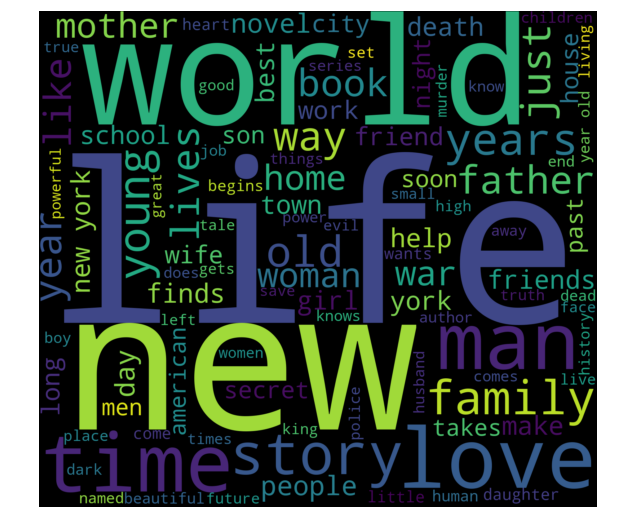

In [80]:
# plotting the word cloud
plt.subplots(figsize=(10, 50))
wordcloud = WordCloud(width=1800,height=1600)
wordcloud.generate_from_frequencies(wordcounts.sort_values(ascending=False).head(100))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [81]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

def tokenize_test(cvec,X_train,X_test,y_train,y_test):
    X_train_vec=cvec.fit_transform(X_train)
    # X_train_vec=cvec.transform(X_train)
    X_test_vec=cvec.transform(X_test)
    print X_train_vec.shape[1],'Features'
    nb=MultinomialNB()
    nb.fit(X_train_vec,y_train)
    y_pred=nb.predict(X_test_vec)
    print 'Accuracy: ',metrics.accuracy_score(y_test,y_pred)
    print 'MultinomialNB Classification Report:\n',metrics.classification_report(y_test,y_pred)

In [82]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2))
tokenize_test(cvec,X_train,X_test,y_train,y_test)

349185 Features
Accuracy:  0.8426678067550235
MultinomialNB Classification Report:
             precision    recall  f1-score   support

       book       0.77      0.97      0.86      1145
       film       0.96      0.72      0.82      1194

avg / total       0.87      0.84      0.84      2339



In [83]:
# what if we limited the features to 1000?
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=1000)
tokenize_test(cvec,X_train,X_test,y_train,y_test)

1000 Features
Accuracy:  0.857631466438649
MultinomialNB Classification Report:
             precision    recall  f1-score   support

       book       0.85      0.86      0.86      1145
       film       0.87      0.85      0.86      1194

avg / total       0.86      0.86      0.86      2339



In [84]:
# what if we limited the features to 1000?
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=10000)
tokenize_test(cvec,X_train,X_test,y_train,y_test)

10000 Features
Accuracy:  0.8926891834117144
MultinomialNB Classification Report:
             precision    recall  f1-score   support

       book       0.88      0.91      0.89      1145
       film       0.91      0.88      0.89      1194

avg / total       0.89      0.89      0.89      2339



In [85]:
# what if we limited the features to 500?
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=500)
tokenize_test(cvec,X_train,X_test,y_train,y_test)

500 Features
Accuracy:  0.8319794784095768
MultinomialNB Classification Report:
             precision    recall  f1-score   support

       book       0.83      0.83      0.83      1145
       film       0.84      0.83      0.84      1194

avg / total       0.83      0.83      0.83      2339



In [86]:
# what if we limited the features to 7000?
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=7000)
tokenize_test(cvec,X_train,X_test,y_train,y_test)

# number of features created
print '# of features: {}'.format(len(cvec.get_feature_names()))

7000 Features
Accuracy:  0.8952543822146216
MultinomialNB Classification Report:
             precision    recall  f1-score   support

       book       0.89      0.90      0.89      1145
       film       0.91      0.89      0.90      1194

avg / total       0.90      0.90      0.90      2339

# of features: 7000


In [136]:
#7000 features seems to be the best indicator
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2),max_features=7000)
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train) # transform the train
X_test_cvec = cvec.transform(X_test) # transform the test

# check the number of words that appears
X_train_df = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names())
wordcounts = X_train_df.sum(axis=0)
wordcounts.sort_values(ascending=False).head(50)

life        2382
new         2033
world       1759
love        1351
time        1292
man         1246
story       1187
family      1146
years       1015
young       1001
old          940
way          850
just         844
year         762
father       757
lives        751
book         714
like         702
mother       668
home         667
war          666
woman        660
people       653
day          652
novel        643
finds        623
help         612
york         611
make         611
new york     605
best         593
town         590
friends      586
girl         581
death        580
school       560
work         553
long         545
friend       540
wife         533
city         531
son          516
secret       507
house        501
soon         501
night        494
past         487
takes        483
men          471
american     464
dtype: int64

In [88]:
#build pipeline
# default: ‘liblinear’ Algorithm to use in the optimization problem.
pipeline_fixed = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1,2),max_features=7000)), ('clf', LogisticRegression())])

# fit the model
pipeline_fixed.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=7000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
       ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [89]:
pipeline_fixed.score(X_test, y_test)

0.8922616502778965

In [90]:
#compare against cross validation
cv_score = cross_val_score(pipeline_base, X_train, y_train, cv=5)
print cv_score

[0.89377289 0.8992674  0.88542621 0.8872594  0.88899083]


In [91]:
#Doing the same with TF-IDF
tfidf_pipe_base = Pipeline([('vectorizer', TfidfVectorizer(stop_words='english',
                                                           ngram_range=(1,2),
                                                           max_features=7000)),
                            ('clf', LogisticRegression())])

tfidf_pipe_base.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=7000, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_id...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [92]:
tfidf_pipe_base.score(X_test, y_test)

0.8986746472851646

In [93]:
#compare against cross validation
cv_score = cross_val_score(tfidf_pipe_base, X_train, y_train, cv=5)
print cv_score

[0.9047619  0.9029304  0.87809349 0.90192484 0.89449541]


In [94]:
vectorizer = tfidf_pipe_base.named_steps['vectorizer']
clf = tfidf_pipe_base.named_steps['clf']

features_names = vectorizer.get_feature_names()
features_names = np.asarray(features_names)
    
print('Number of features: {} \n'.format(len(features_names)))

Number of features: 7000 



In [95]:
lr=LogisticRegression()

In [96]:
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
vectorizer.get_feature_names()

[u'aaron',
 u'abandon',
 u'abandoned',
 u'abbey',
 u'abby',
 u'abducted',
 u'abduction',
 u'abe',
 u'abilities',
 u'ability',
 u'able',
 u'aboard',
 u'abraham',
 u'abroad',
 u'abruptly',
 u'absence',
 u'absent',
 u'absolute',
 u'absolutely',
 u'absorbing',
 u'abuse',
 u'abusive',
 u'academic',
 u'academy',
 u'accept',
 u'acceptance',
 u'accepted',
 u'accepts',
 u'access',
 u'accessible',
 u'accident',
 u'accidental',
 u'accidentally',
 u'accidents',
 u'acclaim',
 u'acclaimed',
 u'acclaimed author',
 u'accompanied',
 u'accompany',
 u'accomplice',
 u'accomplish',
 u'accomplished',
 u'according',
 u'account',
 u'accounts',
 u'accurate',
 u'accused',
 u'ace',
 u'achieve',
 u'achieved',
 u'achievement',
 u'achieving',
 u'aching',
 u'acquaintance',
 u'acquires',
 u'act',
 u'acting',
 u'action',
 u'action packed',
 u'actions',
 u'active',
 u'activist',
 u'activities',
 u'activity',
 u'actor',
 u'actors',
 u'actress',
 u'acts',
 u'actual',
 u'actually',
 u'ad',
 u'adam',
 u'adams',
 u'adaptati

In [98]:
clf.coef_.shape

(1L, 7000L)

In [99]:
top10 = np.argsort(clf.coef_[0])[-10:] 
print('Top 10 keywords found in film/book:')
print((', '.join(features_names[top10])))

Top 10 keywords found in film/book:
father, group, tries, girlfriend, gets, named, decides, team, movie, film


In [100]:
# From the top 10 keywords, we now know that we will have to customize the stopwords.
# We are going to check further what are the top 50 keywordss

top50 = np.argsort(clf.coef_[0])[-50:] 
print('Top 50 keywords found in film/book:')
print((', '.join(features_names[top50])))

Top 50 keywords found in film/book:
doctor, believes, scientist, sent, ben, working, friends, documentary, using, relationship, decide, problems, officer, falls love, lawyer, later, alien, frank, bond, ray, accidentally, johnny, money, company, boss, deal, fall love, trying, gang, starts, goes, son, drug, help, falls, eventually, meets, based, wife, try, father, group, tries, girlfriend, gets, named, decides, team, movie, film


In [101]:
print clf.coef_
features_names.shape

[[ 0.47358151 -0.21199698 -0.15481241 ...  0.65285438  0.1048706
   0.23277326]]


(7000L,)

In [102]:
s =  dict()
for i in np.argsort(clf.coef_[0])[-50:]:
    s[features_names[i]]=clf.coef_[0][i]

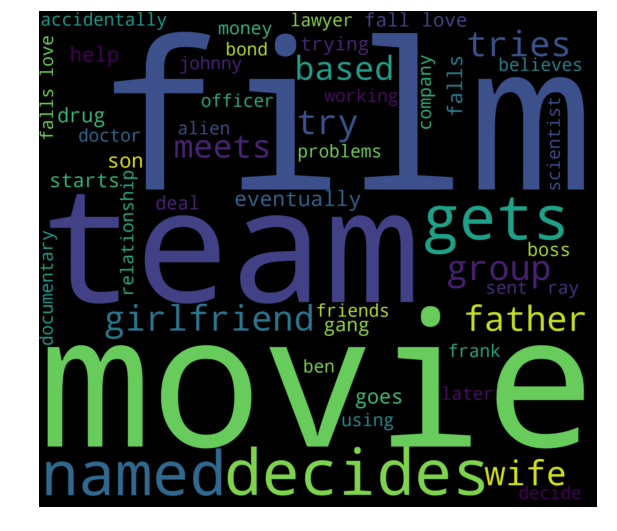

In [103]:
# plotting the word cloud
plt.subplots(figsize=(10, 50))
wordcloud = WordCloud(width=1800,height=1600)
wordcloud.generate_from_frequencies(s)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [104]:
#setting up our customized stop word list
stop = stopwords.words('english')

# Tuning the stop words
# adding new stop words i.e common words that appear that won't help
add_stop = ['sent',
            'charlie',
            'ben',
            'using',
            'problems',
            'decide',
            'later',
            'frank',
            'johnny',
            'starts',
            'trying',
            'goes',
            'falls',
            'eventually',
            'meets',
            'based',
            'try',
            'tries',
            'gets',
            'named',
            'get',
            'led',
            'becomes',
            'accidentally',
            'however',
            'despite',
            'decides']

for word in add_stop:
    stop.append(word)

In [105]:
#Doing the same with TF-IDF
tfidf_pipe_base = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stop,
                                                           ngram_range=(1,2),
                                                           max_features=7000)),
                            ('clf', LogisticRegression())])

tfidf_pipe_base.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=7000, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_id...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [106]:
# the score actually improves a little
tfidf_pipe_base.score(X_test, y_test)

0.8978195810175289

In [107]:
#compare against cross validation
cv_score = cross_val_score(tfidf_pipe_base, X_train, y_train, cv=5)
print cv_score

[0.9047619  0.8956044  0.87626031 0.89092576 0.8853211 ]


In [108]:
#what happens to the top 50 words?
vectorizer = tfidf_pipe_base.named_steps['vectorizer']
clf = tfidf_pipe_base.named_steps['clf']

features_names = vectorizer.get_feature_names()
features_names = np.asarray(features_names)
    
top50 = np.argsort(clf.coef_[0])[-50:] 
print('Top 50 keywords found in film/book:')
print((', '.join(features_names[top50])))

Top 50 keywords found in film/book:
uses, max, crew, married, job, apartment, captain, machine, local, buddy, owner, jack, documentary, car, scientist, lawyer, killed, train, show, peter, several, true story, doctor, police, believes, man, boss, relationship, alien, friends, bond, officer, working, ray, company, money, fall love, deal, gang, find, drug, son, help, wife, group, girlfriend, father, team, movie, film


In [109]:
# found this list of stop words including names
custom = 'aaron, abbey, abbie, abdul, abe, across, abel, abigail, about, above, abraham, abram, abst, accordance, according, act, actually, ada, adah, adalberto, adaline, adam, adan, added, among, addie, adela, adelaida, adelaide, adele, adelia, adelina, adeline, adell, adella, adelle, adena, adina, adj, adolfo, adolph, adopted, adria, adrian, adriana, adriane, adrianna, adrien, adrienne, after, afterwards, afton, again, against, agatha, agnes, agnus, agueda, agustina, ahmad, ahmed, ai, aida, besides, aide, aiko, aileen, ailene, aimee, aja, akilah, al, alaina, alaine, alan, alana, alane, alanna, alayna, alba, albert, alberta, albertha, albertina, albertine, alberto, albina, alda, alden, aldo, alease, alec, alecia, e, aleen, aleisha, eg, alejandra, alejandrina, alejandro, alena, elsewhere, alene, alesha, aleshia, alesia, alessandra, aleta, aletha, everywhere, alethea, alethia, alex, alexander, alexandria, alexia, alexis, alfonso, alfonzo, alfred, alfreda, alfredia, alfredo, ali, alia, alica, alice, alicia, alida, alina, alisa, alise, had, alisha, alishia, alisia, alison, alissa, alita, alix, aliza, all, alla, allan, alleen, allegra, allen, allena, allene, allie, alline, allison, allyn, allyson, alma, hop, almeda, almeta, almost, alona, alone, along, alonso, alonzo, alpha, alphonse, alphonso, already, also, alta, altagracia, altha, althea, although, alton, alva, alvaro, alvera, alverta, alvin, alvina, always, alyce, alycia, alysa, alyse, alysha, alysia, alyson, alyssa, am, amado, amal, amalia, amanda, amber, amberly, ambrose, amee, amelia, long, america, m, ami, amie, amiee, amina, may, amira, ammie, amongst, amos, might, amparo, amy, an, ana, anabel, anamaria, anastacia, anastasia, and, andera, anderson, andra, andre, na, andrea, andreas, andres, andrew, andria, andy, anette, angel, angela, angele, angelena, angeles, angelia, angelic, angelica, angelina, angeline, angelique, angelita, angella, angelo, angelyn, angie, angila, angla, angle, anglea, anh, anibal, anika, anisha, anissa, anita, anitra, anjanette, anjelica, ann, anna, annabel, annabell, annabelle, overall, annalee, annalisa, annamae, annamaria, annamarie, anne, anneliese, annelle, annemarie, put, annetta, annice, annie, rather, annika, annis, annmarie, announce, another, answered, anthony, antione, antionette, antoine, anton, antone, antonetta, antonette, antonia, antonietta, antonina, antonio, antony, antwan, any, anya, anyhow, anyone, anything, anywhere, apolonia, april, apryl, ara, should, araceli, aracelis, aracely, arcelia, archie, ardath, ardelia, ardell, ardella, ardelle, arden, ardis, ardith, are, aren, arent, aretha, argelia, argentina, ariana, arianna, arianne, arica, arie, ariel, arielle, arla, arlean, arleen, arlen, there, arlena, arlene, arletha, arletta, arlette, arlie, arlinda, arline, arlyne, armand, armanda, they, armandina, armando, armida, arminda, arnetta, arnette, arnita, arnold, arnoldo, arnulfo, around, arron, three, art, arthur, artie, arturo, arvilla, as, asa, asha, ashanti, ashely, ashlea, toward, ashlee, ashleigh, ashley, ashli, ashlie, ashly, ashlyn, asia, ask, unlikely, asked, asley, assunta, astrid, ups, at, athena, aubrey, audie, audra, audrea, audrey, audria, audrie, audry, august, augusta, augustina, augustine, augustus, aundrea, aura, aurea, aurelia, aurelio, aurora, aurore, austin, auth, autumn, ava, available, avelina, avery, avis, avril, awilda, ayako, ayana, ayanna, ayesha, azalee, azucena, azzie, b, babara, babette, back, bailey, bambi, bao, barabara, barb, barbara, barbera, barbie, barbra, bari, barney, barrett, barrie, bart, basil, would, basilia, be, bea, beata, beatrice, beatris, beatriz, beau, beaulah, bebe, became, because, becki, becky, become, becomes, becoming, bee, abby, been, before, beforehand, begin, beginning, behind, being, belen, belia, belinda, belkis, bell, bella, belle, below, ben, benedict, benita, benito, benjamin, bennett, benny, benton, berenice, berna, bernadette, bernadine, bernard, bernarda, bernardina, bernardine, bernardo, adrianne, berneice, adriene, bernice, bernie, berniece, bernita, bert, agripina, berta, agustin, bertha, bertie, bertram, beryl, beside, bess, bessie, best, beth, bethanie, aisha, bethann, akiko, bethany, bethel, betsey, bette, better, bettie, bettina, betty, bettyann, bettye, between, beula, beulah, bev, beverlee, beverley, beverly, beyond, bianca, bibi, bill, billie, billy, billye, aleida, birdie, birgit, blaine, blair, blake, blanca, blanch, blanche, blondell, blossom, blythe, bo, bobbi, bobbie, bobbye, alexa, bok, alexandra, bong, bonita, bonnie, bonny, booker, boris, both, boyce, boyd, brad, bradford, bradley, bradly, brady, brain, branda, aline, brande, brandee, branden, brandi, brandon, brandy, brant, breana, breann, breanna, breanne, bree, brenda, brendan, brendon, brenna, brent, brenton, bret, brett, brian, briana, brianne, brice, bridget, bridgett, bridgette, brigette, brigid, brigida, brigitte, brinda, britany, britney, britni, britt, britta, brittaney, brittani, brittanie, britteny, brittni, brittny, brock, broderick, bronwyn, brook, brooke, brooks, bruce, amada, bruna, brunilda, bruno, bryan, bryanna, bryant, bryce, brynn, bryon, bud, buddy, buena, buffy, buford, bula, bunny, burl, burma, burt, burton, buster, but, analisa, by, byron, c, ca, caitlin, caitlyn, calandra, caleb, calista, andree, callie, calvin, camelia, camellia, cameron, camie, camila, camilla, camille, cammy, can, candace, candance, angelika, candelaria, candi, candice, candida, candis, candy, candyce, cannot, cant, caprice, caption, cara, caren, carey, cari, anisa, caridad, carie, carina, carisa, anja, carissa, carita, carl, carla, carlee, carleen, carlena, carlene, carletta, carley, carli, carline, carlita, carlo, carlos, carlota, annett, carlotta, annette, carlton, carly, carlyn, carma, annita, carman, carmel, carmela, carmelia, carmelina, antoinette, carmelita, carmella, carmelo, carmen, carmina, carmine, carmon, carol, carola, carolann, carole, carolee, carolin, caroline, caroll, carolyn, carolyne, carolynn, caron, caroyln, carri, carrie, carrol, carry, carson, cary, caryl, carylon, caryn, casandra, casey, casie, ariane, casimira, cassandra, cassaundra, cassey, cassidy, cassie, cassondra, cassy, catalina, catarina, caterina, catharine, catherin, catherina, catherine, cathern, catheryn, cathey, cathi, cathie, cathleen, cathrine, cathryn, cathy, catina, catrice, catrina, cayla, cecil, cecila, cecile, aron, cecilia, cecille, cecily, cedric, cedrick, celena, celesta, celeste, celestina, celestine, celia, celina, celinda, celine, celsa, ceola, cesar, chad, ashton, chadwick, chae, chan, chana, asuncion, chance, chanda, chandra, chanel, chanell, chanelle, chang, chantal, chantay, chante, chantel, chantell, chantelle, chapter, chara, charis, charise, charissa, charisse, charita, charity, charla, charlena, charlene, charles, charlesetta, charlette, charley, charlie, charline, charlott, charlotte, charlsie, charlyn, charmaine, charolette, chase, chasidy, chasity, chastity, chau, chauncey, chaya, barbar, chelsea, chelsey, chelsie, cher, chere, cheree, cherelle, cheri, barry, cherie, barton, cherilyn, cherish, cherlyn, cherri, cherrie, cherry, cherryl, chery, cheryl, cheryle, cheryll, beckie, chester, chet, cheyenne, chi, chia, chieko, chin, china, ching, belva, chiquita, chloe, chong, chris, chrissy, christa, bennie, christal, christeen, christel, christen, christene, christi, christia, christian, christiana, christiane, christie, christin, bernetta, christina, christine, christinia, christoper, berry, christopher, christy, chrystal, chu, chuck, chun, chung, cicely, ciera, cierra, cinda, cinderella, cindi, cindy, betsy, cinthia, cira, clair, clara, clare, clarence, claretha, claretta, claribel, clarice, clarine, claris, clarisa, clarissa, clarita, billi, clark, classie, claud, claude, claudette, claudia, claudie, claudine, claudio, clay, clayton, clemencia, clement, clemente, clementina, bob, clementine, clemmie, bobby, cleo, bobette, cleopatra, cleora, cleotilde, cleta, cletus, cleveland, cliff, clifford, clifton, clint, clinton, clora, clorinda, clotilde, clyde, co, codi, cody, colby, coleen, brandie, coleman, colene, coletta, colette, colin, colleen, collen, collene, collette, collin, columbus, come, concepcion, conception, concetta, concha, conchita, connie, brianna, conrad, constance, consuela, consuelo, contessa, cora, coral, coralee, coralie, corazon, cordelia, cordell, cordia, cordie, coreen, corene, coretta, corey, brittany, corie, brittney, corina, corine, corinna, corinne, corliss, cornelia, cornelius, cornell, corrie, corrin, corrina, corrine, corrinne, cortez, cortney, could, couldnt, courtney, buck, coy, craig, creola, cried, cris, criselda, bulah, crissy, crista, cristal, cristen, cristi, cristie, cristin, cristina, cristine, cristobal, cristopher, cristy, cruz, crysta, crystal, crystle, cuc, cami, curt, curtis, cyndi, cyndy, cammie, cynthia, cyril, cyrstal, cyrus, cythia, d, dacia, candie, dagmar, candra, dagny, dahlia, daina, daine, daisey, daisy, dakota, dale, dalene, carin, dalia, dalila, dallas, dalton, damaris, damian, damien, damion, damon, dan, dana, danae, dane, carlie, danelle, danette, dani, danial, danica, daniel, daniela, daniele, daniell, daniella, danielle, danika, danille, danilo, danita, dann, danna, dannette, dannie, dannielle, danny, danuta, danyel, danyell, danyelle, daphine, dara, darby, carolina, darcel, darcey, darci, darcie, darcy, darell, daren, daria, darin, dario, carroll, darius, darla, carter, darleen, darlena, darlene, darline, darnell, daron, darrel, darrell, darren, darrick, darrin, cassi, darron, darryl, darwin, daryl, date, dave, david, davida, davina, davis, dawn, dawna, dawne, dayle, dayna, daysi, deadra, dean, deana, deandra, deandre, deandrea, deane, deangelo, cecelia, deann, deanna, deanne, deb, debbi, debbie, debbra, debby, debera, debi, debora, deborah, debra, debrah, debroah, dede, dedra, dee, deeann, deeanna, deedee, deena, deetta, deidra, deidre, deirdre, deja, del, delana, delbert, delcie, delena, delfina, delia, delicia, delila, delilah, delinda, delisa, dell, della, delma, delmar, delmer, delmy, delois, charleen, deloise, delora, deloras, delores, deloris, delorse, delpha, delphia, delphine, delsie, delta, demarcus, charmain, demetra, demetria, chas, demetrice, demetrius, dena, chassidy, denae, deneen, denese, denice, denis, denise, denisha, denita, denna, dennis, dennise, denny, denver, denyse, cherise, deon, cherly, deonna, derek, derick, derrick, deshawn, desirae, desire, desiree, despina, dessie, destiny, detra, devin, devon, devona, devora, devorah, dewayne, dewey, dewitt, dexter, dia, diamond, dian, diana, diane, diann, dianna, christena, dianne, dick, did, didnt, diedra, diedre, diego, dierdre, digna, dillon, dimple, dina, dinah, dino, dinorah, dion, dione, dionna, dionne, ciara, dirk, divina, dixie, do, dodie, does, cindie, doesnt, dollie, dolly, dolores, claire, doloris, domenic, domenica, dominga, domingo, dominic, dominica, clarinda, dominick, dominique, dominque, domitila, domonique, don, dona, donald, donella, donetta, donette, dong, donita, donn, donna, donnell, clelia, donnetta, donnette, donnie, donny, donovan, dont, donte, donya, dora, dorathy, dorcas, doreatha, doreen, dorene, doretha, dorethea, doretta, dori, doria, dorian, dorie, dorinda, dorine, doris, dorla, cole, dorotha, dorothea, dorothy, dorris, dorsey, dortha, dorthea, dorthey, dorthy, dot, dotty, colton, doug, douglas, douglass, dovie, down, doyle, dreama, drew, drucilla, duane, dudley, dulcie, dung, during, dusti, dustin, dusty, dwana, dwayne, dwight, dylan, each, earl, earle, earlean, cori, earleen, earlene, earlie, earline, earnest, earnestine, eartha, easter, eboni, ebonie, ebony, echo, ed, edda, eddie, cory, eddy, edelmira, eden, edgardo, edie, edith, edmond, edmund, edmundo, edna, edra, edris, eduardo, edward, edwardo, edwin, edyth, edythe, effie, efrain, efren, ehtel, eight, eighty, eilene, either, ela, eladia, elaina, elaine, elana, elane, elanor, elayne, elba, elda, elden, eldon, eldora, eldridge, eleanor, eleanora, eleanore, elease, elena, elene, eleni, elenor, elenora, eleonor, eleonora, eleonore, elfreda, elfrieda, elfriede, eli, elia, eliana, elias, dania, elicia, elida, elidia, elijah, elina, elinor, elinore, elisa, elisabeth, elise, eliseo, elisha, elissa, eliz, eliza, elizabeth, elizbeth, elizebeth, dante, elke, ella, ellamae, ellan, ellen, daphne, ellena, elli, ellie, elliot, elliott, ellis, ellsworth, elly, ellyn, elma, elmer, elmira, elmo, elna, elnora, elodia, elois, eloisa, eloise, elouise, eloy, elroy, elsa, else, elsie, elsy, elton, elva, elvera, elvia, elvie, elvina, elvira, elvis, elwanda, elwood, elyse, elza, ema, emanuel, emelda, emelia, emelina, emeline, emely, emerald, emerita, emerson, emery, emiko, emil, emile, emilee, emilia, emilie, emilio, emily, emma, emmaline, emmanuel, emmie, emmitt, emmy, emogene, emory, ena, enda, enedina, deedra, enid, enoch, enola, enough, enrique, enriqueta, epifania, delaine, era, erasmo, eric, erica, erich, erick, ericka, erik, erika, erin, erinn, erlene, erlinda, erline, erma, ermelinda, erminia, erna, ernest, ernestina, ernestine, ernesto, ernie, errol, ervin, erwin, eryn, esmeralda, esperanza, essie, esteban, estefana, estela, estell, estella, estelle, ester, esther, estrella, etc, etha, ethan, denisse, ethel, ethelene, ethelyn, ethyl, etsuko, etta, ettie, eufemia, eugena, eugene, eugenia, eugenie, eugenio, eula, eulah, eulalia, desmond, eun, euna, eunice, eura, eusebia, eusebio, eustolia, evalyn, evan, evangelina, evangeline, eve, evelia, evelin, evelina, eveline, evelyn, evelyne, evelynn, even, ever, everett, everette, every, everyone, everything, evette, evia, evie, evita, evon, evonne, ewa, except, exie, ezekiel, ezequiel, ezra, f, fabian, fabiola, fae, fairy, faith, fallon, fannie, fanny, far, farah, farrah, fatima, fatimah, faustina, faustino, fausto, fawn, fay, faye, fe, felecia, felica, felice, felicia, felicidad, felicita, felicitas, felipa, felipe, felisa, felisha, felix, felton, ferdinand, fermin, fermina, fern, fernanda, fernande, fernando, ferne, few, fidel, fidela, fidelia, fifty, filiberto, filomena, fiona, first, five, flavia, fleta, fletcher, flo, flor, flora, florance, florence, florencia, florencio, florene, dottie, florentina, florentino, floretta, floria, florida, florinda, florine, drema, florrie, flossie, drusilla, floy, floyd, dulce, fonda, duncan, for, forest, former, formerly, dwain, forrest, forty, foster, dyan, found, four, fran, france, francene, frances, francesca, francesco, franchesca, francie, francina, francine, francis, francisca, francisco, francoise, frank, eda, frankie, franklyn, fransisca, fred, freda, edgar, fredda, freddie, edison, freddy, frederic, frederica, frederick, fredericka, fredia, fredric, fredrick, fredricka, freeda, freeman, edwina, freida, frida, frieda, fritz, from, fumiko, eileen, further, g, gabriel, gabriela, gabriele, gabriella, gabrielle, gail, gala, gale, elbert, galen, galina, garfield, garland, garnet, garnett, garret, garrett, garry, gary, gaston, gavin, gay, gaye, elenore, gayla, gayle, gaylene, gaylord, gaynell, gearldine, gema, gemma, gena, gene, genesis, geneva, genevie, genevieve, elin, genevive, genia, genie, genna, gennie, genny, genoveva, geoffrey, georgann, george, georgeann, elizabet, georgeanna, georgene, georgetta, georgette, georgia, georgiana, georgiann, georgianne, georgina, georgine, gerald, geraldine, geraldo, geralyn, gerard, gerardo, gerda, geri, german, gerri, gerry, gertie, gertrude, gertrudis, get, ghislaine, gia, gianna, gidget, gigi, gilbert, gilberte, gilberto, gilda, gillian, gilma, gina, ginette, ginger, elvin, ginny, gino, giovanna, giovanni, gisela, gisele, giselle, gita, giuseppe, giuseppina, gladis, glady, gladys, glayds, glen, glenda, glendora, glenn, glenna, glennie, glennis, glinda, gloria, glory, glynda, glynis, go, golda, golden, emmett, goldie, gonzalo, good, gordon, got, grace, gracia, gracie, eneida, graciela, grady, graham, grant, granville, grayce, grazyna, great, gregg, gregoria, gregorio, gregory, greta, gretchen, gretta, gricelda, grisel, griselda, guadalupe, gudrun, guillermina, guillermo, gus, gussie, gustavo, guy, gwen, gwenda, gwendolyn, gwenn, gwyn, gwyneth, h, ha, hae, hai, esta, hailey, hal, haley, halina, halley, hallie, han, hang, hanh, hank, hanna, hannah, hannelore, hans, harlan, harland, harley, harmony, harold, harriet, harriett, harriette, harris, harrison, harry, harvey, has, hasnt, hassan, hassie, hattie, have, havent, haydee, eva, hayden, hayley, haywood, hazel, he, heath, heather, hector, hed, hedwig, hedy, heide, heidi, heidy, heike, helaine, helen, helena, helene, helga, hellen, hence, henrietta, henriette, henry, her, herb, herbert, here, hereafter, hereby, herein, heres, hereupon, herlinda, herma, herman, hermelinda, hermina, hermine, faviola, herminia, hers, herschel, herself, federico, hershel, hertha, hes, hester, hettie, hid, hien, hilaria, hilario, hilary, hilda, hildegard, hildred, hillary, hilma, hilton, him, himself, hipolito, hiroko, his, hoa, hobert, holley, holli, hollie, holly, home, homer, honey, hong, hope, horace, horacio, hortencia, hortense, hortensia, hosea, houston, how, howard, however, hoyt, hubert, huey, hugh, hui, hulda, humberto, hundred, hung, hunter, huong, hwa, hye, hyman, hyo, hyon, i, ian, id, ida, idalia, idell, idella, ie, iesha, if, ignacio, franklin, ike, ilana, ileana, ileen, ilene, iliana, ill, illa, ilona, ilse, iluminada, im, ima, imelda, imogene, in, inc, include, includes, indeed, index, india, indira, inell, ines, inez, information, inga, inge, ingeborg, inger, ingrid, inocencia, instead, internet, into, iola, iona, garth, ione, iraida, irena, irene, iris, irish, irma, irmgard, irvin, irving, gaynelle, is, isa, isaac, isabel, genaro, isabell, isabella, isadora, isaiah, isaias, isaura, isela, isiah, isidra, isidro, isis, ismael, isnt, isobel, israel, isreal, issac, it, its, itself, ivan, ivana, ive, georgianna, ivelisse, georgie, ivey, ivonne, ivory, ivy, izetta, izola, j, ja, jacalyn, jacelyn, germaine, jacinda, jacinta, jacinto, gertha, jackeline, gertrud, jackelyn, jacki, gertude, jackie, jacklyn, jackqueline, jackson, jaclyn, gil, jacob, jacqualine, jacque, jacquelin, jacqueline, jacquelyne, jacquelynn, jacques, jacquetta, jacqui, jacquie, jacquiline, jacquline, jacqulyn, jada, jadwiga, jae, jaime, jaimee, jaimie, jake, jaleesa, jalisa, jama, jamaal, jamal, jamar, jame, jamee, jamel, james, jamey, jami, jamie, jamika, jamila, jamison, jammie, jan, jana, janae, janay, jane, janean, janee, janeen, graig, janel, janell, janella, janelle, greg, janene, janessa, janet, janeth, janett, janetta, janette, janey, jani, janice, grover, janie, janina, janine, janis, janise, janita, jann, janna, jannet, jannette, jannie, january, janyce, jaqueline, jaquelyn, jared, jarod, jarred, jarrett, jarrod, jarvis, jasmin, jason, jasper, hana, jaunita, javier, jay, jaye, jayme, jaymie, jayna, jayne, jayson, jazmin, jazmine, jc, jean, jeana, jeane, jeanelle, jeanene, jeanett, jeanetta, jeanette, jeanice, jeanie, jeanine, jeanmarie, jeanna, jeanne, jeannetta, jeannette, jeannie, jeannine, jed, jeff, hee, jefferey, jefferson, jeffery, jeffie, jeffrey, jeffry, jen, jena, jenae, jene, jenee, jenell, jenelle, jenette, jeneva, heriberto, jeni, jenice, jenifer, jeniffer, hermila, jenine, jenise, jenna, jennefer, jennell, herta, jennette, jenni, jennie, hiedi, jennifer, jenniffer, jennine, jerald, jeraldine, hilde, jeramy, hildegarde, jere, jeremiah, jeri, jerica, jerilyn, hiram, jermaine, hisako, jerold, jerome, jeromy, jerrell, jerri, hollis, jerrica, jerrie, jerrod, jerrold, jerry, jesica, jess, jesse, jessenia, jessi, jessia, jessica, jessika, jestine, hsiu, jesus, hue, jesusa, jesusita, hugo, jetta, jettie, jewel, jewell, ji, jill, jillian, hyacinth, jim, jimmie, jin, jina, hyun, jinny, jo, joan, joana, joane, joann, ignacia, joanna, joanne, ila, joannie, ilda, joaquin, joaquina, jocelyn, jodee, jodi, jodie, jody, joeann, joel, joella, joelle, joellen, ina, joesph, joetta, joette, joey, johana, johanna, johanne, john, johna, johnathan, johnathon, johnetta, johnie, johnna, ira, johnnie, johnny, johnsie, irina, johnson, joi, joie, jolanda, joleen, jolene, irwin, jolie, joline, jolyn, jolynn, jon, isabelle, jona, jonah, jonas, jonathon, jone, jonell, jonelle, jong, joni, jonie, jonna, jonnie, jordan, jordon, iva, jorge, jose, josef, ivette, josefa, josefina, josefine, joselyn, joseph, josephina, josephine, josette, josh, joshua, josiah, josie, jack, joslyn, jospeh, josphine, josue, jovan, joy, joya, joyce, joycelyn, joye, juan, juana, juanita, jacquelyn, jude, judi, judie, judith, judson, judy, julee, julene, jules, juli, jade, julia, julian, juliana, juliane, juliann, julianna, julianne, julie, julieann, julienne, juliet, julieta, julietta, juliette, julio, julissa, julius, june, jung, junie, junior, junita, junko, just, justa, justina, justine, jutta, k, ka, kacey, kaci, kacie, kacy, kai, kaila, kaitlin, kaitlyn, kala, kaleigh, kaley, kali, kallie, kalyn, kam, kamala, janiece, kami, kamilah, kandace, kandice, kandis, kandra, kandy, kanesha, kanisha, kara, karan, kareem, kareen, karen, karena, karey, kari, karie, karima, karin, karina, jasmine, karine, karisa, karissa, karl, karla, karleen, karlene, karly, karlyn, karma, karmen, karol, karole, karoline, karolyn, karon, karren, karri, karrie, karry, kary, karyl, karyn, kasandra, kasha, kasi, kassandra, kassie, kate, katelin, katelyn, katelynn, katerine, kathaleen, katharina, katharine, katharyn, kathe, katheleen, katherin, katherine, kathern, kathey, kathi, kathie, kathleen, kathlene, kathline, kathlyn, kathrin, kathrine, kathryn, kathryne, kathy, kathyrn, kati, katia, katie, katlyn, katrice, katrina, kattie, katy, kay, jenny, kayce, kaycee, kaye, kayla, kaylee, jeremy, kayleen, kayleigh, kaylene, jerlene, kazuko, kecia, keeley, keely, keena, keesha, keiko, keila, keira, keisha, keith, jesenia, keitha, keli, kelle, kelley, kelli, kellie, kelly, jessie, kellye, kelsey, kelsi, kelsie, kelvin, kemberly, ken, kena, kenda, kendal, kendall, kendra, kendrick, keneth, jimmy, kenia, kenisha, kenna, kenneth, kenny, kent, kenton, joanie, kenyatta, kenyetta, kera, keren, keri, kermit, kerri, kerrie, kerry, kerstin, kesha, joe, keshia, keturah, keva, keven, kevin, khadijah, khalilah, kia, kiana, kiara, kiera, kiersten, kiesha, kieth, kim, kimber, kimberlee, johnette, kimberley, kimberlie, kimberly, kimbery, kimbra, kimi, kimiko, kina, kindra, king, kira, kirby, kirk, kirsten, kirstie, kirstin, kisha, kit, kittie, jonathan, kitty, kiyoko, kizzie, kizzy, klara, know, korey, kori, kortney, kory, kourtney, kraig, kris, krishna, krissy, krista, kristal, kristan, kristeen, kristel, kristen, kristi, kristian, kristie, kristin, kristina, kristine, kristofer, kristy, kristyn, krysta, jovita, krystal, krysten, krystin, krystina, krystle, krystyna, kum, kurt, kurtis, kyla, kyle, kylee, kylie, kym, jule, kymberly, kyoko, kyong, kyra, kyung, l, lacey, lachelle, laci, lacie, lacresha, lacy, ladawn, ladonna, lady, lael, lahoma, lai, laine, lajuana, lakeesha, lakeisha, lakendra, lakenya, lakesha, lakeshia, lakia, lakiesha, justin, lakisha, lakita, lala, lamonica, lamont, lan, lana, lance, landon, lane, lanell, lanelle, lanette, lani, lanie, lanita, lannie, lanny, lanora, laquanda, laquita, lara, larae, kandi, laraine, laree, larhonda, larisa, larissa, larita, laronda, larraine, larry, larue, lasandra, lashanda, lashandra, lashaun, lashaunda, lashawn, lashawna, lashay, lashell, lashon, lashonda, lashunda, last, latanya, latasha, latashia, later, latesha, latia, laticia, latina, latisha, latonia, latonya, latoria, latosha, latoya, latoyia, latrice, latricia, latrina, latrisha, kasey, latter, latterly, kasie, launa, laura, lauralee, lauran, laure, laureen, laurel, lauren, laurena, laurence, laurene, lauretta, laurette, lauri, katherina, laurice, laurie, katheryn, laurinda, laurine, lauryn, lavada, lavelle, lavenia, lavera, lavern, laverna, laverne, laveta, lavette, lavinia, lavon, lavona, lavonda, katina, lavone, lavonia, lavonna, lawana, lawanda, lawanna, lawerence, lawrence, layla, layne, lazaro, le, lea, leah, lean, leana, leandra, leandro, leann, keenan, leanna, leanne, leanora, least, leatha, leatrice, lecia, leda, leeann, kellee, leeanna, leeanne, leena, leesa, left, leia, leida, leif, leigh, leigha, leighann, leila, leilani, leisa, leisha, lekisha, lela, lelah, leland, lelia, lemuel, len, kennith, lena, lenard, lenita, kenya, lenna, lennie, lenny, lenora, lenore, leo, leola, leoma, leon, leona, leonard, leonarda, leonardo, leone, leonel, leonia, leonida, leonie, leonila, leonor, leonora, leonore, leontine, leopoldo, leora, kiley, leota, lera, kimberely, leroy, les, kimberli, lesa, lesha, lesia, leslee, lesley, lesli, leslie, less, lessie, kip, lester, let, leta, letha, leticia, letisha, letitia, lets, lettie, letty, levi, lewis, lezlie, li, lia, liana, liane, lianne, libbie, libby, liberty, librada, lida, lidia, lien, lieselotte, ligia, like, likely, lila, lili, lilia, lilian, liliana, lilla, kristle, lilli, kristopher, lillia, lilliam, lillian, lilliana, lillie, lilly, lily, lin, lina, lincoln, linda, lindsay, lindsey, lindsy, lindy, line, linette, ling, linh, links, linn, linnea, linnie, lino, linsey, linwood, lionel, lisa, lisabeth, lisandra, lisbeth, lise, lisette, lisha, laila, lissa, lissette, lita, livia, liz, liza, lizabeth, lizbeth, lizeth, lizette, lizzette, lizzie, ll, lamar, lloyd, loan, logan, loida, lois, lola, lolita, loma, lon, lona, lang, londa, loni, lonna, lonnie, lonny, lora, loraine, loralee, lore, lorean, loree, loreen, lorelei, loren, lorena, lorene, lorenza, lorenzo, loreta, loretta, lorette, lori, loria, loriann, lorie, lorilee, lashawnda, lorinda, loris, lorita, lorna, lorraine, lasonya, lorretta, latarsha, lorri, lorriane, lorrie, lorrine, lory, lottie, lou, louanne, louella, louetta, louie, louis, louisa, louise, loura, lourdes, lourie, love, lovella, lovetta, lovie, lowell, loyce, loyd, ltd, lu, luana, luann, luanna, luanne, luba, lucas, luci, lucia, luciano, lucie, lucien, lucienne, lucila, lucilla, lucille, lucina, lucio, lucius, lucrecia, lavina, lucretia, lucy, ludie, ludivina, luella, luetta, luigi, lavonne, luis, luisa, luise, luke, lula, lulu, luna, lupe, lupita, lura, lurlene, lurline, luther, luvenia, luz, lyda, lydia, lyla, lyle, lyman, lyn, lynda, lyndia, lee, lyndon, lyndsay, lyndsey, lynell, lynelle, lynette, lynn, lynna, lynne, lynnette, lynsey, lynwood, mabel, mabelle, mable, mac, machelle, macie, mack, mackenzie, macy, madalene, madaline, madalyn, maddie, made, madelaine, madeleine, madelene, madeline, madelyn, madge, madie, madison, madlyn, madonna, mae, maegan, mafalda, magali, magaly, magan, magaret, magda, magdalen, magdalena, magdalene, magen, maggie, magnolia, mahalia, mai, maia, maida, maile, maira, maire, maisha, maisie, major, majorie, make, makeda, makes, malcolm, malcom, malena, malia, malik, malika, malinda, malisa, lexie, malissa, malka, mallie, mallory, malorie, mamie, mammie, man, mana, manda, mandi, mandie, mandy, manie, manual, manuel, manuela, many, maple, mara, maragaret, maragret, maranda, marc, marcel, marcela, marcelina, marceline, marcelino, marcell, marcella, marcelle, marcellus, marcelo, marcene, marchelle, marcia, marcie, marcos, marcus, marcy, maren, marg, margareta, margarett, margaretta, margarette, margarita, margarite, margarito, margart, margene, margeret, margert, margery, marget, margherita, margie, margit, margo, margorie, margret, margrett, marguerita, marguerite, margurite, margy, marhta, mari, maria, loise, mariah, mariam, marian, mariana, marianela, mariann, marianna, marianne, mariano, maribel, maribeth, marica, maricela, maricruz, marie, mariel, mariela, mariella, marietta, mariette, mariko, marilee, marilou, marilu, marilyn, marilynn, marin, marina, marinda, marine, mario, marion, lorina, maris, lorine, marisa, marisela, marisha, marisol, marissa, marita, maritza, marivel, marjory, mark, marketta, markita, louann, markus, marla, marlana, marleen, marlen, marlena, marlene, marlin, marline, marlo, louvenia, marlon, marlyn, marlys, marna, marni, marnie, marquerite, marquetta, marquis, marquita, marquitta, marry, marsha, marshall, marth, martha, luciana, marti, martin, martina, martine, marty, lucile, marva, marvel, marvella, lucinda, marvin, marvis, marx, mary, marya, maryalice, maryam, lue, maryann, maryanna, maryanne, marybelle, marybeth, maryellen, maryetta, maryjane, maryjo, maryland, marylee, marylin, maryln, marylou, marylouise, marylyn, marylynn, maryrose, masako, mason, matha, mathew, mathilda, mathilde, matilda, matilde, matt, matthew, mattie, maud, maude, lynetta, maudie, maura, maureen, maurice, mauricio, maurine, maurita, ma, mauro, mavis, max, maxie, maxima, maximina, maximo, maxine, maxwell, maya, maybe, maybell, maybelle, maye, mayme, maynard, mayola, mayra, mazie, mckenzie, mckinley, me, meagan, meaghan, meantime, meanwhile, mechelle, meda, mee, meg, megan, meggan, meghan, meghann, mei, mel, melaine, melani, melania, melanie, melany, melba, melda, melia, melida, melina, melinda, melisa, melissa, melissia, melita, mellie, mellisa, mellissa, melodee, melodi, melodie, melody, melonie, melony, melva, malvina, melvin, melvina, mendy, mercedes, mercedez, mercy, meredith, meri, merideth, meridith, merilyn, merissa, merle, mao, merlene, merlin, merlyn, merna, merri, merrie, merrilee, merrill, marcelene, merry, mertie, mervin, meryl, meta, mi, mia, mica, micaela, micah, marci, michael, michaela, marco, michaele, michal, michale, mardell, micheal, michel, margaret, michele, margarete, michelina, micheline, michell, michelle, michiko, mickey, micki, marge, mickie, miesha, migdalia, mignon, miguelina, mika, mikaela, mike, mikel, miki, margot, mikki, milagro, milagros, milan, milda, mildred, miles, milford, milissa, millard, millie, million, milly, milo, milton, mimi, min, mina, minda, mindi, mindy, minerva, ming, minh, minna, minnie, minta, marielle, miquel, mira, miranda, mireille, mireya, miriam, mirian, mirna, mirta, mirtha, misha, miss, missy, misti, mistie, misty, mitch, mitchel, mitchell, mitsue, mitsuko, mittie, marjorie, mitzi, mitzie, miyoko, modesto, mohamed, mohammad, mohammed, moira, mollie, molly, moment, mona, monet, monica, monika, monique, monnie, monroe, monserrate, monte, monty, moon, mora, more, moreover, morgan, moriah, morris, marta, morton, mose, moses, moshe, most, mostly, mozell, mozella, mozelle, mr, mrs, much, mui, muoi, murray, must, my, myesha, myles, myong, myra, myrl, myrle, myrna, myron, myrta, myrtie, myrtle, myself, myung, n, nada, nadene, nadia, naida, nakesha, nakia, nakisha, nakita, nam, namely, nan, nana, nancee, nancey, nanci, nancie, nancy, nanette, nannette, nannie, naoma, naomi, napoleon, narcisa, natacha, natalia, natalie, natalya, natasha, natashia, nathalie, nathanael, nathanial, natisha, natividad, natosha, neal, near, necole, ned, neda, nedra, neely, neida, neil, neither, nelda, nelia, nelida, nell, nella, nelle, nellie, nelly, nelson, nena, nenita, neoma, neomi, nereida, nerissa, nery, nestor, neta, nettie, neva, nevada, never, nevertheless, neville, new, newton, next, nga, ngan, ngoc, nguyet, nia, nichelle, nichol, nicholas, nichole, melynda, nicholle, nick, nicki, nickie, nickole, nicky, nicol, nicola, nicolas, nicolasa, nicole, nicolette, nicolle, nida, nidia, niesha, nieves, nigel, niki, nikia, nikita, nikki, nikole, nila, nilda, nilsa, nina, nine, ninety, micha, ninfa, nisha, nita, no, noah, noble, nobody, nobuko, noe, noel, noelia, noella, noelle, noemi, nola, nolan, noma, nona, none, miguel, nonetheless, noone, nor, nora, norah, norbert, norberto, mila, noreen, noriko, norine, norma, norman, normand, not, nothing, nova, millicent, novella, now, nowhere, nu, nubia, numbers, nydia, nyla, o, obdulia, ocie, octavia, octavio, oda, odelia, odell, odessa, odette, odilia, odis, mirella, of, ofelia, off, often, oh, ola, olen, olene, oleta, olevia, olga, olimpia, olin, olinda, oliva, olive, oliver, olivia, ollie, olympia, oma, modesta, omar, omega, omer, omitted, on, moises, ona, once, one, oneida, ones, onie, onita, only, onto, opal, ophelia, or, oralee, oralia, ord, oren, oretha, orlando, orpha, orval, orville, oscar, ossie, osvaldo, oswaldo, otelia, muriel, otha, other, others, otherwise, otilia, otis, myriam, otto, ouida, our, ours, ourselves, myrtice, out, myrtis, over, owen, own, ozell, ozella, ozie, nadine, p, pa, pablo, page, pages, paige, palma, palmer, palmira, pamala, pamela, pamelia, pamella, pamila, pamula, pansy, paola, paris, parker, part, parthenia, particia, pasquale, pasty, pat, patience, nathan, patria, patrica, nathaniel, patrice, patricia, patrina, patsy, patti, pattie, patty, paula, paulene, paulette, pauline, paulita, paz, pearl, pearle, pearlene, pearlie, pearline, pearly, pedro, peg, peggie, peggy, pei, penelope, penney, penni, pennie, penny, per, percy, perhaps, perla, perry, pete, peter, petra, petrina, petronila, phebe, phil, philip, phillip, phillis, philomena, phung, phuong, nickolas, phylicia, phylis, phyliss, pia, piedad, pierre, ping, pinkie, piper, pok, polly, porfirio, porsche, porsha, porter, portia, pp, precious, preston, pricilla, prince, princess, priscila, priscilla, proud, providencia, prudence, q, qiana, queen, queenie, quentin, quiana, quincy, quinn, nohemi, quintin, quinton, quyen, r, rachael, rachal, racheal, rachel, rachele, norene, rachell, rachelle, racquel, rae, raeann, norris, raelene, rafael, rafaela, raguel, raina, raisa, raleigh, ralph, ramiro, ramon, ramona, ramonita, ran, rana, ranae, randa, randal, randall, randee, ok, randi, randolph, ranee, raphael, raquel, rashad, rasheeda, rashida, raul, raven, ray, raye, rayford, raymon, raymond, raymonde, raymundo, rayna, re, rea, reagan, reatha, reba, rebbeca, rebbecca, ora, rebeca, rebecca, rebecka, rebekah, recent, recently, reed, reena, ref, refs, refugia, refugio, regan, regena, regenia, reggie, regina, reginald, regine, reginia, reid, reiko, reina, reinaldo, reita, related, rema, remedios, remona, pam, rena, renaldo, renata, renate, renato, renay, pandora, renda, renea, renetta, renita, replied, research, ressie, reta, retha, retta, reuben, reva, rex, reyes, patrick, reyna, reynaldo, rhea, rheba, rhett, paul, rhiannon, rhoda, pauletta, rhona, paulina, rhonda, ria, ricardo, rich, richard, richelle, richie, rick, rickey, ricki, rickie, ricky, rico, rigoberto, rikki, riley, rima, rina, risa, rita, rivka, robbi, robbie, robby, robbyn, robena, robert, roberta, roberto, robin, robt, robyn, rocco, phoebe, rochel, rochell, rochelle, rocio, rocky, phyllis, rod, roderick, rodger, pilar, rodney, rodolfo, rodrick, rodrigo, rogelio, roger, roland, rolanda, rolande, rolando, rolf, rolland, roma, romaine, roman, romana, romelia, romeo, romona, pura, ron, rona, ronald, roni, ronna, ronni, ronnie, ronny, roosevelt, rory, rosa, rosalba, rosalee, rosalia, rosalie, rosalind, rosalinda, rosaline, rosalva, rosalyn, rosamaria, rosamond, rosana, rosann, rosanna, rosanne, rosaria, rosario, rosaura, roscoe, rose, roseann, roseanna, roseanne, roselee, roselia, roseline, rosella, randell, roselle, roselyn, randy, rosemarie, rosemary, rosena, rosenda, rosendo, rosetta, rosette, rosia, rosie, rosina, rosio, raylene, roslyn, ross, rossana, rossie, rosy, rowena, roxana, reanna, roxane, roxann, roxanna, roxanne, roxie, roy, royal, royce, reda, rozanne, rozella, ruben, rubi, rubie, rubin, rubye, rudolf, rudolph, rudy, rueben, rufina, rufus, run, rupert, russel, russell, rusty, ruth, rutha, ruthann, renae, ruthanne, ruthe, ruthie, ryan, ryann, s, rene, sabina, renee, sabine, sabra, renna, sabrina, sacha, sachiko, sade, sadie, sadye, sage, rey, said, sal, reynalda, salena, salina, salley, sallie, sally, salome, salvador, salvatore, sam, ricarda, samantha, samara, samatha, same, samella, samira, sammie, sammy, samual, samuel, sana, sanda, sandee, sandi, sandie, sandra, sandy, sanford, riva, sang, rob, sanjuana, sanjuanita, robbin, sanora, santa, santana, santiago, santo, santos, sara, sarah, sarai, saran, sari, sarina, sarita, sasha, saturnina, sau, saul, saundra, savanna, say, scarlet, scarlett, scot, scott, scottie, scotty, sean, search, season, sebastian, sebrina, sec, section, see, seem, seema, seemed, seeming, seems, ronda, selena, selene, selina, selma, sena, senaida, september, serafina, serena, sergio, serina, serita, rosalina, server, seth, seven, seventy, several, seymour, sha, shad, shae, shaina, shakia, shakita, shala, shalanda, shall, shalon, shalonda, shameka, shamika, shan, shana, shanae, shanda, shandi, shandra, shane, shaneka, shanel, shanell, shanelle, shanice, shanika, shaniqua, shanita, shannan, shannon, rosita, shanon, shanta, shantae, shantay, shante, shantel, shantell, shantelle, shanti, shaquana, shaquita, shara, roxy, sharan, sharda, sharee, sharell, sharen, shari, sharice, sharie, sharika, ruby, sharilyn, sharla, sharleen, sharlene, sharmaine, sharolyn, sharon, sharri, russ, sharyl, sharyn, shasta, shaun, shauna, shaunda, shaunna, shaunta, shaunte, shavon, shavonda, shavonne, shawana, shawanda, shawanna, shawn, shawnda, shawnee, shawnna, shawnta, shay, shayla, shayna, shayne, she, shea, sheba, shed, sheena, sheila, sheilah, shela, shelba, shelby, sheldon, shelia, shell, shella, shelley, shelli, shellie, shelly, shemeka, shemika, shena, shenika, shenita, shenna, shera, sheree, sherell, sheri, sherice, sheridan, sherie, santina, sherika, sherill, sherilyn, sherise, sherita, sherlene, sherley, sherly, sherlyn, sherman, sheron, sherrell, sherri, sherrie, sherril, savannah, sherrill, sherron, sherry, sherryl, sherwood, shery, sheryl, sheryll, shes, shiela, shila, shiloh, shin, shira, shirely, shirl, shirlee, shirleen, shirlene, shirley, shirly, shizue, shizuko, shon, shona, setsuko, shonda, shondra, shonna, shonta, shoshana, shu, shakira, shyla, sibyl, sid, sidney, sierra, signe, sigrid, silas, silva, silvana, silvia, sima, simon, simona, simone, simonne, sina, since, shani, sindy, siobhan, sirena, siu, shanna, six, sixty, skye, slyvia, so, socorro, sofia, soila, sol, solange, soledad, solomon, some, somehow, someone, somer, something, sometime, sometimes, somewhere, sommer, son, sona, sharita, sondra, song, sonia, sonja, sonny, sonya, sharonda, soo, sharron, sook, soon, sophia, sophie, soraya, sparkle, spencer, spring, stacee, stacey, staci, stacia, stacie, stacy, stanford, shawna, stanley, stanton, star, starla, starr, stefan, stefani, stefania, stefanie, stefany, steffanie, stella, stepanie, stephan, stephane, stephani, stephania, stephanie, stephen, stephenie, stephine, stephnie, sterling, shelton, steve, steven, stevie, stewart, still, stop, stormy, stuart, suanne, such, sudie, sue, sueann, suellen, suk, sulema, sumiko, summer, sun, sunday, sung, sunni, sunny, sunshine, susan, susana, susann, susanna, susannah, susanne, susie, susy, suzan, suzann, suzanna, suzanne, suzette, suzi, suzy, svetlana, sybil, syble, sydney, sylvester, sylvia, sylvie, synthia, syreeta, t, ta, tabetha, tabitha, tad, tai, taina, taisha, tajuana, takako, taking, takisha, talia, talisha, talitha, tama, tamar, tamara, tamatha, tambra, tameika, tameka, tamekia, tamela, tamera, tamesha, tami, tamica, tamie, tamiko, tamisha, sixta, tammara, tammera, tammi, tammie, tammy, tana, tandra, tandy, taneka, tanesha, tangela, tania, tanika, tanja, tanna, tanner, tara, tarah, taren, tarra, tarsha, taryn, tasha, tashia, tashina, tasia, tatiana, tatum, tatyana, taunya, tawana, tawanda, tawanna, tawna, tawnya, stan, taylor, tayna, ted, teddy, tegan, tell, stasia, telma, temeka, temika, tempie, temple, ten, tena, tenesha, stephaine, tenisha, tennie, tennille, teodora, teodoro, stephany, teofila, tequila, tera, tereasa, terence, teresa, teresia, teresita, teressa, teri, terica, su, terina, terisa, terra, terrance, terrell, terrence, terresa, terri, terrie, terrilyn, terry, tesha, tessa, tessie, thad, thaddeus, thalia, than, thanh, thao, that, thatll, thats, thatve, the, theda, their, thelma, them, suzie, themselves, then, thence, theo, theodora, theodore, theola, thereafter, thereby, thered, therefore, tabatha, therein, therell, therere, theres, theresa, therese, theressa, thereupon, thereve, theron, thersa, these, tam, theyd, tamala, theyll, theyre, theyve, thi, thing, think, thirty, this, thomas, thomasena, thomasina, thomasine, thora, tamika, those, though, thought, thousand, thresa, through, throughout, tamra, thru, thu, thurman, thus, thuy, tia, tiana, tianna, tanisha, tiara, tien, tiera, tanya, tierra, tiesha, tifany, tari, tiffaney, tiffani, tiffanie, tiffany, tiffiny, tijuana, til, tilda, till, tillie, tim, timika, timmy, timothy, tina, tawny, tinisha, tiny, tip, tisa, tish, teena, tisha, teisha, titus, to, tobi, tobias, tobie, toby, toccara, tod, together, toi, told, tom, tomas, tomasa, tomeka, tomi, tomika, tomiko, terese, tommie, tommy, tommye, tomoko, tona, tonda, tonette, toney, tonia, tonie, tonisha, tonita, tonja, tony, tonya, too, tora, tess, tori, torie, torri, torrie, tory, tosha, toshia, thea, toshiko, tova, towanda, towards, toya, tracee, traci, tracie, theresia, tracy, tran, trang, travis, treasa, treena, trena, trent, trenton, tresa, tressa, tressie, treva, trevor, trey, tricia, trillion, trina, trinh, trinidad, trinity, trisha, trista, tristan, troy, trudi, trudie, trudy, trula, truman, try, tu, tuan, tula, tuyet, twana, twanda, twanna, twenty, twila, two, twyla, ty, tyesha, tyisha, tyler, tynisha, todd, tyra, tyree, tyron, tyrone, tyson, u, ulrike, ulysses, un, una, under, unless, unlike, until, unto, up, toni, upon, ursula, us, used, usha, using, ute, v, vada, val, valarie, valda, valencia, valene, valentin, valentina, valentine, valeri, valeria, valerie, tracey, valery, valorie, valrie, van, vanda, vanesa, vanessa, vanetta, vania, vanita, vanna, vannesa, vannessa, vashti, vasiliki, vaughn, ve, veda, velda, velia, vella, velma, trish, velva, velvet, vena, venessa, venetta, venice, venita, vennie, venus, veola, vera, verda, verdell, verdie, verena, vergie, verla, verlene, verlie, verline, vern, verna, vernell, vernetta, vernia, tyrell, vernice, vernie, vernita, ula, vernon, verona, veronica, veronika, veronique, versie, vertie, very, vesta, veta, vi, via, vicenta, vicente, vickey, vickie, vicky, victor, victoria, vida, vallie, viki, vikki, vilma, vance, vina, vince, vincent, vincenza, vincenzo, vinita, vinnie, viola, violet, violeta, violette, virgen, virgie, virgil, virgilio, virgina, virginia, vita, vito, viva, vivan, vivian, viviana, vivien, vivienne, vol, vols, von, voncile, vonda, vonnie, vs, w, wade, wai, waldo, walker, wallace, wally, walter, walton, waltraud, wan, wanda, waneta, wanetta, wanita, ward, warner, warren, was, wasnt, wava, way, waylon, wayne, we, wed, vicki, wei, weldon, well, wen, victorina, wendell, wendi, wendie, wendolyn, wendy, wenona, went, were, werent, werner, wes, wesley, weston, weve, what, whatever, whatll, whats, whatve, when, whence, whenever, where, whereafter, whereas, whereby, wherein, wheres, whereupon, wherever, whether, which, while, whim, whither, whitley, whitney, who, whod, whoever, whole, wholl, whom, whomever, whos, whose, why, wilber, wilbert, wilbur, wilburn, wilda, wiley, wilford, wilfred, wilfredo, wilhelmina, wilhemina, will, willa, willard, willena, willene, willetta, willette, willia, william, williams, willian, willie, williemae, willis, willodean, willow, willy, wilma, wilmer, wilson, wilton, windy, winford, winfred, winifred, winnie, winnifred, winona, winston, winter, with, within, without, wm, wonda, wont, woodrow, words, wouldnt, wyatt, wynell, wynona, x, xavier, xenia, xiao, xiomara, xochitl, xuan, y, yadira, yaeko, yael, yahaira, yajaira, yan, yang, yanira, yasmin, yasmine, yasuko, yee, yelena, yen, yer, yes, yesenia, yessenia, yet, yetta, yevette, yi, ying, yoko, yolanda, yolande, yolando, yolonda, yon, yong, yoshie, yoshiko, you, youd, youlanda, youll, young, your, youre, yours, yourself, yourselves, youve, yu, yuette, yuk, yuki, yukiko, yuko, yulanda, yun, yung, yuonne, yuri, yuriko, yvette, yvone, yvonne, z, zachariah, zachary, zachery, zack, zackary, zada, zaida, zana, zandra, zane, zelda, zella, zelma, zena, zenaida, zenia, zenobia, zetta, zina, zita, zoe, zofia, zoila, zola, zona, zonia, zora, zoraida, zula, zulema, zulma'
custom = custom.split(',')
for word in custom:
    stop.append(word)

In [110]:
#Doing the same with TF-IDF
tfidf_pipe_base = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stop,
                                                           ngram_range=(1,2),
                                                           max_features=7000)),
                            ('clf', LogisticRegression())])

tfidf_pipe_base.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=7000, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_id...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [111]:
# the score actually improves a little
tfidf_pipe_base.score(X_test, y_test)

0.8982471141513467

In [112]:
#compare against cross validation
cv_score = cross_val_score(tfidf_pipe_base, X_train, y_train, cv=5)
print cv_score

[0.9047619  0.8956044  0.8771769  0.8872594  0.88623853]


In [113]:
#what happens to the top 50 words?
vectorizer = tfidf_pipe_base.named_steps['vectorizer']
clf = tfidf_pipe_base.named_steps['clf']

features_names = vectorizer.get_feature_names()
features_names = np.asarray(features_names)
    
top50 = np.argsort(clf.coef_[0])[-50:] 
print('Top 50 keywords found in film/book:')
print((', '.join(features_names[top50])))

Top 50 keywords found in film/book:
uses, max, crew, married, captain, apartment, machine, job, owner, buddy, local, jack, killed, documentary, car, scientist, show, lawyer, train, peter, several, doctor, true story, police, believes, man, boss, friends, alien, relationship, officer, bond, ray, working, company, money, fall love, gang, find, deal, drug, son, help, wife, group, father, girlfriend, team, movie, film


In [114]:
s =  dict()
for i in np.argsort(clf.coef_[0])[-50:]:
    s[features_names[i]]=clf.coef_[0][i]

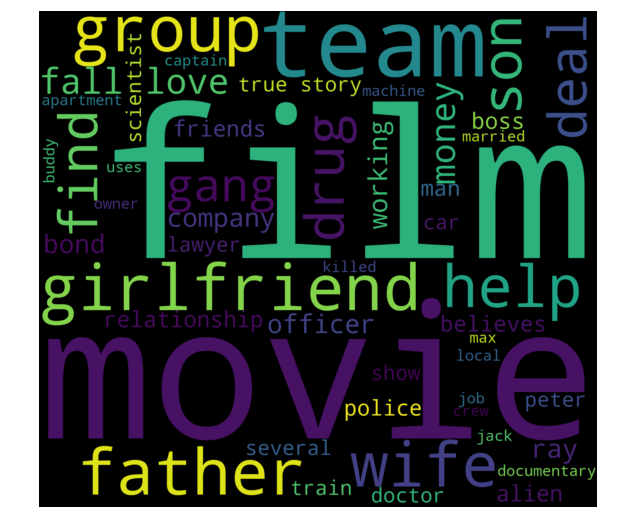

In [115]:
# plotting the word cloud
plt.subplots(figsize=(10, 50))
wordcloud = WordCloud(width=1800,height=1600)
wordcloud.generate_from_frequencies(s)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [116]:
film = df[df.type=='film'].summary

#Doing the same with TF-IDF
checker = CountVectorizer(stop_words=stop, ngram_range=(1,2), max_features=7000)
checker.fit(film)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=7000, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u"you're", u"you've", u"you'll", u"you'd", u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u"she's", u'her', u'hers', u'herself', u'it', u"it's", u'its', u'itself', u'th..., ' zofia', ' zoila', ' zola', ' zona', ' zonia', ' zora', ' zoraida', ' zula', ' zulema', ' zulma'],
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [117]:
checker_cvec = checker.transform(film) 
checker.get_feature_names()
checker_df = pd.DataFrame(checker_cvec.todense(), columns=checker.get_feature_names())
wordcounts = checker_df.sum(axis=0)
print 'The top 10 common words'
print wordcounts.sort_values(ascending=False).head(10)

The top 10 common words
one       1257
life      1204
new        963
two        823
man        818
time       700
find       674
world      670
family     643
young      641
dtype: int64


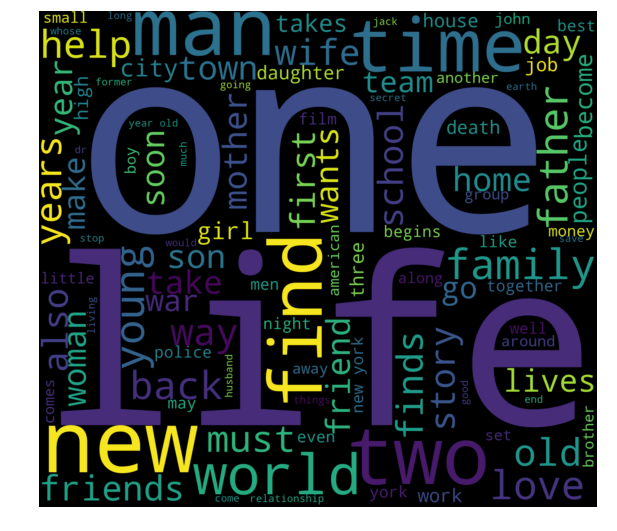

In [118]:
# plotting the word cloud for 100 words for film
plt.subplots(figsize=(10, 50))
wordcloud = WordCloud(width=1800,height=1600)
wordcloud.generate_from_frequencies(wordcounts.sort_values(ascending=False).head(100))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [119]:
book = df[df.type=='book'].summary

#Doing the same with TF-IDF
checker = CountVectorizer(stop_words=stop, ngram_range=(1,2), max_features=7000)
checker.fit(book)

checker_cvec = checker.transform(book) 
checker.get_feature_names()
checker_df = pd.DataFrame(checker_cvec.todense(), columns=checker.get_feature_names())
wordcounts = checker_df.sum(axis=0)
print 'The top 10 common words'
print wordcounts.sort_values(ascending=False).head(10)

The top 10 common words
one       2658
life      2139
new       1979
world     1774
love      1362
story     1234
time      1127
first     1090
family     975
years      946
dtype: int64


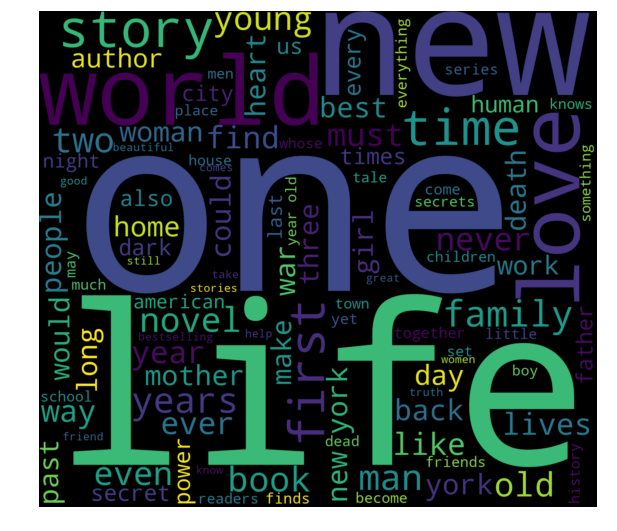

In [120]:
# plotting the word cloud for 100 words for book
plt.subplots(figsize=(10, 50))
wordcloud = WordCloud(width=1800,height=1600)
wordcloud.generate_from_frequencies(wordcounts.sort_values(ascending=False).head(100))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [121]:
cvec =  TfidfVectorizer(analyzer='word',stop_words=stop, ngram_range=(1,2), min_df=0, max_features=7000)
tokenize_test(cvec,X_train,X_test,y_train,y_test)

# number of features created
print 'TF-IDF with # of features: {}'.format(len(cvec.get_feature_names()))

7000 Features
Accuracy:  0.8888413852073536
MultinomialNB Classification Report:
             precision    recall  f1-score   support

       book       0.88      0.89      0.89      1145
       film       0.89      0.89      0.89      1194

avg / total       0.89      0.89      0.89      2339

TF-IDF with # of features: 7000


In [122]:
# recommender
tf = TfidfVectorizer(analyzer='word',stop_words=stop, ngram_range=(1,2),min_df=0,max_features=7000)
tfidf_matrix_ultra = tf.fit_transform(df['genre_summary'])
tfidf_matrix_ultra.shape

(7795, 7000)

In [123]:
cosine_sim_ultra = linear_kernel(tfidf_matrix_ultra, tfidf_matrix_ultra)

In [124]:
get_Recommendations('Avengers, The (2012)','book',cosine_sim_ultra)

For the recommendataion of Avengers, The (2012):


,title,type,genre,cos_sin score
6084,Marvel 1602,book,"['sequential art', 'graphic novels', 'sequenti...",0.165550
5718,The Stand: Soul Survivors,book,"['sequential art', 'graphic novels', 'horror',...",0.159524
7680,"Peril at End House (Hercule Poirot, #8)",book,"['mystery', 'fiction', 'mystery', 'crime', 'cl...",0.135144
4100,Digital Fortress,book,"['fiction', 'thriller', 'mystery', 'suspense']",0.128366
5171,"Furies of Calderon (Codex Alera, #1)",book,"['fantasy', 'fiction', 'fantasy', 'epic fantas...",0.114369
3972,Gone Girl,book,"['fiction', 'mystery', 'thriller', 'mystery', ...",0.107418
6348,"Consent to Kill (Mitch Rapp, #8)",book,"['thriller', 'fiction', 'action', 'spy thrille...",0.106624
6976,"Captivate (Need, #2)",book,"['young adult', 'fantasy', 'fantasy', 'paranor...",0.104962
7193,The Royal We,book,"['romance', 'fiction', 'womens fiction', 'chic...",0.103930
5287,"Changes (The Dresden Files, #12)",book,"['fantasy', 'urban fantasy', 'fantasy', 'ficti...",0.102310


In [125]:
get_Recommendations('Avengers, The (2012)','film',cosine_sim_ultra)

For the recommendataion of Avengers, The (2012):


,title,type,genre,cos_sin score
605,Captain America: The Winter Soldier (2014),film,"['action', 'adventure', 'sci-fi', 'imax']",0.305691
603,Captain America: Civil War (2016),film,"['action', 'sci-fi', 'thriller']",0.263188
2187,Man of Steel (2013),film,"['action', 'adventure', 'fantasy', 'sci-fi', '...",0.223541
2267,Men in Black (a.k.a. MIB) (1997),film,"['action', 'comedy', 'sci-fi']",0.205157
3927,Youth in Revolt (2009),film,"['comedy', 'drama', 'romance']",0.188646
1486,Guardians of the Galaxy (2014),film,"['action', 'adventure', 'sci-fi']",0.176192
2259,Megamind (2010),film,"['action', 'animation', 'children', 'comedy', ...",0.175539
323,Basic Instinct (1992),film,"['crime', 'mystery', 'thriller']",0.171912
3055,"Score, The (2001)",film,"['action', 'drama']",0.170588
2807,Prometheus (2012),film,"['action', 'horror', 'sci-fi', 'imax']",0.168652


In [126]:
# recommender
tf2 = TfidfVectorizer(analyzer='word',stop_words='english', ngram_range=(1,2),min_df=0)
tfidf_matrix = tf2.fit_transform(df['genre_summary'])
tfidf_matrix.shape

(7795, 482797)

In [127]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [128]:
get_Recommendations('Avengers, The (2012)','book',cosine_sim)

For the recommendataion of Avengers, The (2012):


,title,type,genre,cos_sin score
4921,Frindle,book,"['realistic fiction', 'childrens', 'fiction', ...",0.057758
5718,The Stand: Soul Survivors,book,"['sequential art', 'graphic novels', 'horror',...",0.049505
6361,"Kick-Ass (Kick-Ass, #1)",book,"['sequential art', 'comics', 'sequential art',...",0.049391
7680,"Peril at End House (Hercule Poirot, #8)",book,"['mystery', 'fiction', 'mystery', 'crime', 'cl...",0.038603
4100,Digital Fortress,book,"['fiction', 'thriller', 'mystery', 'suspense']",0.035713
4121,Watchmen,book,"['sequential art', 'graphic novels', 'sequenti...",0.034979
6348,"Consent to Kill (Mitch Rapp, #8)",book,"['thriller', 'fiction', 'action', 'spy thrille...",0.032624
5287,"Changes (The Dresden Files, #12)",book,"['fantasy', 'urban fantasy', 'fantasy', 'ficti...",0.030248
3972,Gone Girl,book,"['fiction', 'mystery', 'thriller', 'mystery', ...",0.028435
5171,"Furies of Calderon (Codex Alera, #1)",book,"['fantasy', 'fiction', 'fantasy', 'epic fantas...",0.028219


In [129]:
get_Recommendations('Avengers, The (2012)','film',cosine_sim)

For the recommendataion of Avengers, The (2012):


,title,type,genre,cos_sin score
603,Captain America: Civil War (2016),film,"['action', 'sci-fi', 'thriller']",0.164995
605,Captain America: The Winter Soldier (2014),film,"['action', 'adventure', 'sci-fi', 'imax']",0.121603
3550,Thor: The Dark World (2013),film,"['action', 'adventure', 'fantasy', 'imax']",0.078619
2187,Man of Steel (2013),film,"['action', 'adventure', 'fantasy', 'sci-fi', '...",0.072070
1794,Iron Man 3 (2013),film,"['action', 'sci-fi', 'thriller', 'imax']",0.061518
2267,Men in Black (a.k.a. MIB) (1997),film,"['action', 'comedy', 'sci-fi']",0.058309
2807,Prometheus (2012),film,"['action', 'horror', 'sci-fi', 'imax']",0.058009
323,Basic Instinct (1992),film,"['crime', 'mystery', 'thriller']",0.054433
2880,Reindeer Games (2000),film,"['action', 'thriller']",0.052952
1793,Iron Man 2 (2010),film,"['action', 'adventure', 'sci-fi', 'thriller', ...",0.052423


In [130]:
search_title('Hobbit')

                                                 title  type
1613         Hobbit: An Unexpected Journey, The (2012)  film
1614       Hobbit: The Desolation of Smaug, The (2013)  film
3496  The Hobbit: The Battle of the Five Armies (2014)  film
3949                                        The Hobbit  book
4274                         The Hobbit: Graphic Novel  book


In [131]:
get_Recommendations('The Hobbit','film',cosine_sim)

For the recommendataion of The Hobbit:


,title,type,genre,cos_sin score
1613,"Hobbit: An Unexpected Journey, The (2012)",film,"['adventure', 'fantasy', 'imax']",0.110523
2108,"Lord of the Rings: The Fellowship of the Ring,...",film,"['adventure', 'fantasy']",0.082883
2107,"Lord of the Rings, The (1978)",film,"['adventure', 'animation', 'children', 'fantasy']",0.074275
3569,Time Bandits (1981),film,"['adventure', 'comedy', 'fantasy', 'sci-fi']",0.064885
434,"Black Hole, The (1979)",film,"['children', 'sci-fi']",0.044294
366,Beethoven (1992),film,"['children', 'comedy', 'drama']",0.041549
1616,Holes (2003),film,"['adventure', 'children', 'comedy', 'mystery']",0.035133
131,Alice in Wonderland (1951),film,"['adventure', 'animation', 'children', 'fantas...",0.028432
3496,The Hobbit: The Battle of the Five Armies (2014),film,"['adventure', 'fantasy']",0.027583
1012,Dragonslayer (1981),film,"['action', 'adventure', 'fantasy']",0.027031


In [132]:
get_Recommendations('The Hobbit','film',cosine_sim_ultra)

For the recommendataion of The Hobbit:


,title,type,genre,cos_sin score
2108,"Lord of the Rings: The Fellowship of the Ring,...",film,"['adventure', 'fantasy']",0.200554
2107,"Lord of the Rings, The (1978)",film,"['adventure', 'animation', 'children', 'fantasy']",0.182588
434,"Black Hole, The (1979)",film,"['children', 'sci-fi']",0.178928
1614,"Hobbit: The Desolation of Smaug, The (2013)",film,"['adventure', 'fantasy', 'imax']",0.152694
366,Beethoven (1992),film,"['children', 'comedy', 'drama']",0.109114
1616,Holes (2003),film,"['adventure', 'children', 'comedy', 'mystery']",0.101357
132,Alice in Wonderland (2010),film,"['adventure', 'fantasy', 'imax']",0.091651
1252,Flipper (1996),film,"['adventure', 'children']",0.084658
131,Alice in Wonderland (1951),film,"['adventure', 'animation', 'children', 'fantas...",0.084050
581,Butch Cassidy and the Sundance Kid (1969),film,"['action', 'western']",0.083696


In [133]:
get_Recommendations('The Hobbit','book',cosine_sim)

For the recommendataion of The Hobbit:


,title,type,genre,cos_sin score
4274,The Hobbit: Graphic Novel,book,"['fantasy', 'sequential art', 'graphic novels'...",0.161528
3961,The Fellowship of the Ring (The Lord of the Ri...,book,"['fantasy', 'classics', 'fiction', 'adventure']",0.107671
4119,"The Lord of the Rings (The Lord of the Rings, ...",book,"['fantasy', 'classics', 'fiction']",0.097354
5738,"Firefight (The Reckoners, #2)",book,"['fantasy', 'young adult', 'science fiction', ...",0.067287
4086,"The Two Towers (The Lord of the Rings, #2)",book,"['fantasy', 'classics', 'fiction', 'adventure']",0.052724
5536,"The Snowman (Harry Hole, #7)",book,"['mystery', 'mystery', 'crime', 'fiction', 'th...",0.046573
6013,"Flaggermusmannen (Harry Hole, #1)",book,"['mystery', 'mystery', 'crime', 'thriller']",0.040702
4635,The Jungle,book,"['classics', 'fiction', 'historical', 'histori...",0.039435
6999,"Panserhjerte (Harry Hole, #8)",book,"['mystery', 'crime', 'mystery', 'fiction', 'th...",0.038128
7400,"Police (Harry Hole, #10)",book,"['mystery', 'crime', 'mystery', 'fiction', 'th...",0.036667
